This notebook is a raw version of the cleaned notebook named `xai-for-afrikaans-misinformation`. This notebook does include additional code that was used to compare translation models, where the resulting scores were visualised in the research report. The parallel corpora used in this notebook (i.e. NLLB, CCMatrix) can be found [here](https://opus.nlpl.eu/), while the Autshumato data can be found [here](https://sourceforge.net/projects/autshumato/). Note the Afrikaans-to-English translations were used and these datasets were only used for experiment purposes.

To run this notebook, please use a Kaggle environment by uploading this notebook to Kaggle.

In [ ]:
# Installs
! pip install pandas
! pip install sacremoses

! pip install -U nltk
# ! pip install nltk==3.2.4
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!pip install lime

In [ ]:
# Imports
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk import word_tokenize
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import pandas as pd
import re
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from collections import Counter
import nltk
nltk.download('punkt_tab')
from transformers import BertModel, BertTokenizerFast
import torch.nn.functional as F
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from lime.lime_text import LimeTextExplainer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# Set seed
seed = 42

# Evaluation of different models using BLEU scores

## Parallel Corpora

This notebook acknowledges and uses corpora which can be found at the [OPUS collection](https://opus.nlpl.eu/).

<hr>

### **CCMatrix**

**Latest Release:**
- v1

This corpus has been extracted from web crawls using the margin-based bitext mining techniques described at [LASER GitHub](https://github.com/facebookresearch/LASER/tree/master/tasks/CCMatrix).

<hr>

### **NLLB**

**Latest Release:**
- v1

**License:**
- ODC-By

This dataset was developed from metadata for mined bitext provided by Meta AI. It includes bitext for 148 English-centric and 1465 non-English-centric language pairs, utilizing the stopes mining library and LASER3 encoders (Heffernan et al., 2022). The total size of the dataset is approximately 450GB. This release is based on data packages available at Hugging Face and AllenAI. Detailed information about instances for each language pair in the original data is available in the `dataset_infos.json` file. Data filtering was done based on language identification, emoji filtering, and for some high-resource languages, a language model. For more details on data filtering, see Section 5.2 (NLLB Team et al., 2022). Mappings between the original NLLB language IDs and OPUS language IDs are available in this table. Sentence alignments include LASER3 scores (refer to XCES align files), language ID scores, source information, and URLs from where the data was extracted (refer to language XML files).

<hr>

**Papers cited:**

- Holger Schwenk, Guillaume Wenzek, Sergey Edunov, Edouard Grave, Armand Joulin, and Angela Fan. *CCMatrix: Mining Billions of High-Quality Parallel Sentences on the WEB.*
- Angela Fan, Shruti Bhosale, Holger Schwenk, Zhiyi Ma, Ahmed El-Kishky, Siddharth Goyal, Mandeep Baines, Onur Celebi, Guillaume Wenzek, Vishrav Chaudhary, Naman Goyal, Tom Birch, Vitaliy Liptchinsky, Sergey Edunov, Edouard Grave, Michael Auli, and Armand Joulin. *Beyond English-Centric Multilingual Machine Translation.*

Additionally, we acknowledge OPUS for the service provided here by citing:

- Jörg Tiedemann. *Parallel Data, Tools and Interfaces in OPUS.*

<hr>

**BIBTEX citation:**

```bibtex
@inproceedings{tiedemann-2012-parallel,
    title = "Parallel Data, Tools and Interfaces in {OPUS}",
    author = {Tiedemann, J{\"o}rg},
    editor = "Calzolari, Nicoletta  and
      Choukri, Khalid  and
      Declerck, Thierry  and
      Do{\u{g}}an, Mehmet U{\u{g}}ur  and
      Maegaard, Bente  and
      Mariani, Joseph  and
      Moreno, Asuncion  and
      Odijk, Jan  and
      Piperidis, Stelios",
    booktitle = "Proceedings of the Eighth International Conference on Language Resources and Evaluation ({LREC}'12)",
    month = may,
    year = "2012",
    address = "Istanbul, Turkey",
    publisher = "European Language Resources Association (ELRA)",
    url = "http://www.lrec-conf.org/proceedings/lrec2012/pdf/463_Paper.pdf",
    pages = "2214--2218",
    abstract = "This paper presents the current status of OPUS, a growing language resource of parallel corpora and related tools. The focus in OPUS is to provide freely available data sets in various formats together with basic annotation to be useful for applications in computational linguistics, translation studies and cross-linguistic corpus studies. In this paper, we report about new data sets and their features, additional annotation tools and models provided from the website and essential interfaces and on-line services included in the project.",
}
```

### Load parallel corpus

In [ ]:
# def load_parallel_corpus(src_path, tgt_path):
#     with open(src_path, 'r', encoding='utf-8') as src_file:
#         source_texts = src_file.readlines()
#         if len(source_texts) > 10000:
#             source_texts = source_texts[:10000]

#     with open(tgt_path, 'r', encoding='utf-8') as tgt_file:
#         target_texts = tgt_file.readlines()
#         if len(target_texts) > 10000:
#             target_texts = target_texts[:10000]

#     return source_texts, target_texts

# def clean_data(source_texts, target_texts):
#     cleaned_source_texts = []
#     cleaned_target_texts = []
#     pattern = "<Doc"

#     for source, target in zip(source_texts, target_texts):
#         if not re.search(pattern, source) and not re.search(pattern, target):
#             cleaned_source_texts.append(source)
#             cleaned_target_texts.append(target)

#     return cleaned_source_texts, cleaned_target_texts

# # Paths to your parallel corpus files
# # src_path = '/kaggle/input/ccmatrix/CCMatrix.af-en.en'
# # tgt_path = '/kaggle/input/ccmatrix/CCMatrix.af-en.af'
# src_path = '/kaggle/input/opus-nllb/NLLB.af-en.en'
# tgt_path = '/kaggle/input/opus-nllb/NLLB.af-en.af'
# # src_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.English.Translator1.txt'
# # tgt_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.Afrikaans.Translator1.txt'

# # Load the parallel corpus
# source_texts, target_texts = load_parallel_corpus(src_path, tgt_path)

# # print(f'Source text before cleaning: {source_texts[:2]}')
# # print(f'Target text before cleaning: {target_texts[:2]}')

# # # Clean the data
# # source_texts, target_texts = clean_data(source_texts, target_texts)

# # print(f'Source text after cleaning: {source_texts[:2]}')
# # print(f'Target text after cleaning: {target_texts[:2]}')

# # # Combine Autshumato files into one file for source and one for target
# # # First file
# # src_one_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.English.Translator1.txt'
# # tgt_one_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.Afrikaans.Translator1.txt'
# # # Second file
# # src_two_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.English.Translator2.txt'
# # tgt_two_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.Afrikaans.Translator2.txt'
# # # Third file
# # src_three_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.English.Translator3.txt'
# # tgt_three_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.Afrikaans.Translator3.txt'
# # # Fourth file
# # src_four_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.English.Translator4.txt'
# # tgt_four_path = '/kaggle/input/autshumato/Autshumato.EvaluationSet.Afrikaans.Translator4.txt'

# # src_paths = [src_one_path, src_two_path, src_three_path, src_four_path]
# # tgt_paths = [tgt_one_path, tgt_two_path, tgt_three_path, tgt_four_path]

# # source_texts = []
# # target_texts = []

# # for src_path, tgt_path in zip(src_paths, tgt_paths):
# #     new_source, new_target = load_parallel_corpus(src_path, tgt_path)
    
# #     source_texts.extend(new_source)
# #     target_texts.extend(new_target)

# # Batch size for translation
# batch_size = 8

# # Define sample size
# sample_size = 10000 # currently we set it to the full sample (we only read the first 10000 lines in the function above)

## Analysis on data

In [ ]:
# # Extract sentence lengths (in words) into list
# source_sentence_lengths = [len(sentence.split()) for sentence in source_texts]
# target_sentence_lengths = [len(sentence.split()) for sentence in target_texts]

# # Calculate frequency distributions
# source_length_counts = Counter(source_sentence_lengths)
# target_length_counts = Counter(target_sentence_lengths)

# # Sort the lengths for consistent plotting
# sorted_source_lengths = sorted(source_length_counts.keys())
# sorted_source_counts = [source_length_counts[length] for length in sorted_source_lengths]

# sorted_target_lengths = sorted(target_length_counts.keys())
# sorted_target_counts = [target_length_counts[length] for length in sorted_target_lengths]

# plt.figure(figsize=(10,10))

# # 1st plot - Box plot for source sentence lengths
# plt.subplot(2, 2, 1)
# plt.boxplot(source_sentence_lengths, vert=False, patch_artist=True,
#             boxprops=dict(facecolor='skyblue', color='blue', alpha=0.7),
#             medianprops=dict(color='red'))
# plt.title('Box Plot of Sentence Lengths (in words) for Source Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.yticks([])

# # 2nd plot - Bar plot for source sentence lengths
# plt.subplot(2, 2, 2)
# plt.bar(sorted_source_lengths, sorted_source_counts, color='blue', alpha=0.7)
# plt.title('Distribution of Sentence Lengths (in words) for Source Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.ylabel('Number of Occurrences')

# # 3rd plot - Box plot for target sentence lengths
# plt.subplot(2, 2, 3)
# plt.boxplot(target_sentence_lengths, vert=False, patch_artist=True,
#             boxprops=dict(facecolor='lightgreen', color='green', alpha=0.7),
#             medianprops=dict(color='red'))
# plt.title('Box Plot of Sentence Lengths (in words) for Target Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.yticks([])

# # 4th plot - Bar plot for target sentence lengths
# plt.subplot(2, 2, 4)
# plt.bar(sorted_target_lengths, sorted_target_counts, color='green', alpha=0.7)
# plt.title('Distribution of Sentence Lengths (in words) for Target Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.ylabel('Number of Occurrences')

# # Adjust layout to prevent overlapping
# plt.tight_layout()

# # Show plot
# plt.show()

In [ ]:
# # IQR
# source_Q1 = np.percentile(source_sentence_lengths, 25, method='midpoint')
# source_Q3 = np.percentile(source_sentence_lengths, 75, method='midpoint')
# source_IQR = source_Q3 - source_Q1
# print(source_IQR)

# # Above Upper bound
# upper_bound = source_Q3+1.5*source_IQR
# upper_array = np.array(source_sentence_lengths >= upper_bound)
# print("Upper Bound:", upper_bound)
# print(upper_array.sum())

# # Below Lower bound
# lower_bound = source_Q1-1.5*source_IQR
# lower_array = np.array(source_sentence_lengths <= lower_bound)
# print("Lower Bound:", lower_bound)
# print(lower_array.sum())

# # Remove outliers
# filtered_source_texts = []
# filtered_target_texts = []

# for source_sentence, target_sentence, length in zip(source_texts, target_texts, source_sentence_lengths):
#     if lower_bound <= length <= upper_bound:
#         filtered_source_texts.append(source_sentence)
#         filtered_target_texts.append(target_sentence)

# # Extract sentence lengths (in words) into list
# source_sentence_lengths = [len(sentence.split()) for sentence in filtered_source_texts]
# target_sentence_lengths = [len(sentence.split()) for sentence in filtered_target_texts]

# # Calculate frequency distributions
# source_length_counts = Counter(source_sentence_lengths)
# target_length_counts = Counter(target_sentence_lengths)

# # Sort the lengths for consistent plotting
# sorted_source_lengths = sorted(source_length_counts.keys())
# sorted_source_counts = [source_length_counts[length] for length in sorted_source_lengths]

# sorted_target_lengths = sorted(target_length_counts.keys())
# sorted_target_counts = [target_length_counts[length] for length in sorted_target_lengths]

# plt.figure(figsize=(10,10))

# # 1st plot - Box plot for source sentence lengths
# plt.subplot(2, 2, 1)
# plt.boxplot(source_sentence_lengths, vert=False, patch_artist=True,
#             boxprops=dict(facecolor='skyblue', color='blue', alpha=0.7),
#             medianprops=dict(color='red'))
# plt.title('Box Plot of Sentence Lengths (in words) for Filtered Source Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.yticks([])

# # 2nd plot - Bar plot for source sentence lengths
# plt.subplot(2, 2, 2)
# plt.bar(sorted_source_lengths, sorted_source_counts, color='blue', alpha=0.7)
# plt.title('Distribution of Sentence Lengths (in words) for Filtered Source Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.ylabel('Number of Occurrences')

# # 3rd plot - Box plot for target sentence lengths
# plt.subplot(2, 2, 3)
# plt.boxplot(target_sentence_lengths, vert=False, patch_artist=True,
#             boxprops=dict(facecolor='lightgreen', color='green', alpha=0.7),
#             medianprops=dict(color='red'))
# plt.title('Box Plot of Sentence Lengths (in words) for Filtered Target Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.yticks([])

# # 4th plot - Bar plot for target sentence lengths
# plt.subplot(2, 2, 4)
# plt.bar(sorted_target_lengths, sorted_target_counts, color='green', alpha=0.7)
# plt.title('Distribution of Sentence Lengths (in words) for Filtered Target Text')
# plt.xlabel('Sentence Length (number of words)')
# plt.ylabel('Number of Occurrences')

# # Adjust layout to prevent overlapping
# plt.tight_layout()

# # Show plot
# plt.show()

In [ ]:
# Function to translate text from one language to another
def translate_texts(texts, src_lang, tgt_lang, model_name):
    if 'mbart' in model_name.lower():
        # mBART-50-MM settings
        tokenizer.src_lang = src_lang
        encoded_texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
        generated_tokens = model.generate(
            **encoded_texts,
            forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
            max_length=512,
            num_beams=4,
            early_stopping=True
        )
    elif 'helsinki' in model_name.lower():
        # Helsinki settings
        encoded_texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
        generated_tokens = model.generate(
            **encoded_texts,
            max_length=512,
            num_beams=4,
            early_stopping=True
        )
    else:
        raise ValueError("Unsupported model name. Please use 'mbart' or 'helsinki' in the model name.")
    
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

def translate_texts_in_batches(text_from_source, text_from_target=None, src_lang='en_XX', tgt_lang='af_ZA', batch_size=8, model_name='helsinki'):
    translated_texts = []
    reference_texts = []

    # Translate texts in batches
    for i in range(0, len(text_from_source), batch_size):
        batch_source_texts = text_from_source[i:i+batch_size]
        if text_from_target is not None:
            batch_target_texts = text_from_target[i:i+batch_size]

        # Translate the batch of source texts
        translated_batch = translate_texts([text.strip() for text in batch_source_texts], src_lang, tgt_lang, model_name)  # English-to-Afrikaans

        # Store the translated and reference texts
        translated_texts.extend([text.split() for text in translated_batch])
        if text_from_target is not None:
            reference_texts.extend([[text.strip().split()] for text in batch_target_texts])

        # Clear GPU cache
        torch.cuda.empty_cache()

    if text_from_target is not None:
        return translated_texts, reference_texts
    else:
        return translated_texts

def calculate_bleu_scores(translated_texts, reference_texts):
    # Use smoothing function
    smooth_fn = SmoothingFunction().method7

    # Calculate BLEU scores with smoothing
    bleu_scores = [sentence_bleu(ref, trans, smoothing_function=smooth_fn) for ref, trans in zip(reference_texts, translated_texts)]
    average_bleu_score = sum(bleu_scores) / len(bleu_scores)

    print(f"Average BLEU score with smoothing: {average_bleu_score}")
    return bleu_scores
    
def calculate_meteor_scores(translated_texts, reference_texts):
    # Calculate METEOR scores
    meteor_scores = [meteor_score([word_tokenize(" ".join(trans))], word_tokenize(" ".join(ref[0]))) for trans, ref in zip(translated_texts, reference_texts)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)

    print(f"Average METEOR score: {average_meteor_score}\n")
    return meteor_scores

def plot_sentence_length_comparison(categories, avg_bleu_scores, avg_meteor_scores):
    x = range(len(categories))
    plt.figure(figsize=(10, 5))
    
    plt.plot(x, avg_bleu_scores, label='BLEU', marker='o', linestyle='--', color='blue')
    plt.plot(x, avg_meteor_scores, label='METEOR', marker='s', linestyle='--', color='green')
    
    plt.xticks(x, categories)
    plt.xlabel("Sentence Length Range")
    plt.ylabel("Scores")
    plt.title("BLEU and METEOR Scores by Sentence Length Range")
    plt.legend()
    plt.grid(True)
    plt.figtext(0.5, -0.1, "Note: Sentence length is measured in the number of words", wrap=True, horizontalalignment='center', fontsize=10)
    plt.show()

def compare_scores_by_length(translated_texts, reference_texts):
    # Get scores
    bleu_scores = calculate_bleu_scores(translated_texts, reference_texts)
    meteor_scores = calculate_meteor_scores(translated_texts, reference_texts)

    # Initialise categories for sentence lengths (number of words)
    length_categories = {
        '(0,10]': (0, 10),
        '(10,20]': (10, 20),
        '(20,30]': (20, 30),
        '(30,+∞]': (30, float('inf'))
#         '(30,40]': (30, 40),
#         '(40,50]': (40, 50),
#         '(50,+∞]': (50, float('inf'))
    }
    
    length_bleu_scores = {category: [] for category in length_categories}
    length_meteor_scores = {category: [] for category in length_categories}
    
    for trans, ref, bleu, meteor in zip(translated_texts, reference_texts, bleu_scores, meteor_scores):
        length = len(trans)
        for category, (min_len, max_len) in length_categories.items():
            if min_len <= length < max_len:
                length_bleu_scores[category].append(bleu)
                length_meteor_scores[category].append(meteor)
                break

    avg_bleu_scores = []
    avg_meteor_scores = []
    categories = []

    for category in length_categories:
        avg_bleu = sum(length_bleu_scores[category]) / len(length_bleu_scores[category]) if length_bleu_scores[category] else 0
        avg_meteor = sum(length_meteor_scores[category]) / len(length_meteor_scores[category]) if length_meteor_scores[category] else 0
        avg_bleu_scores.append(avg_bleu)
        avg_meteor_scores.append(avg_meteor)
        categories.append(category)
        print(f"Average BLEU score for {category} sentences: {avg_bleu}")
        print(f"Average METEOR score for {category} sentences: {avg_meteor}")

    plot_sentence_length_comparison(categories, avg_bleu_scores, avg_meteor_scores)
    
def plot_comparison_across_different_sample_sizes(sample_sizes, all_avg_bleu_scores, all_avg_meteor_scores):
    x = range(len(sample_sizes))
    plt.figure(figsize=(10, 5))
    
    plt.plot(x, all_avg_bleu_scores, label='BLEU', marker='o', linestyle='--', color='blue')
    plt.plot(x, all_avg_meteor_scores, label='METEOR', marker='s', linestyle='--', color='green')
    
    plt.xticks(x, sample_sizes)
    plt.xlabel("Sample Size Used")
    plt.ylabel("Average Scores")
    plt.title("Average BLEU and METEOR Scores by Sample Sizes")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def compare_scores_across_different_sample_sizes(source_texts, target_texts, sample_sizes, src_lang, tgt_lang, batch_size, model_name):
    all_avg_bleu_scores = []
    all_avg_meteor_scores = []
    
    for sample_size in sample_sizes:
        model_source_texts = source_texts[:sample_size]
        model_target_texts = target_texts[:sample_size]
        # Translate texts in batches
        translated_texts, reference_texts = translate_texts_in_batches(model_source_texts, model_target_texts, src_lang, tgt_lang, batch_size, model_name)
    
        # Get scores
        bleu_scores = calculate_bleu_scores(translated_texts, reference_texts)
        meteor_scores = calculate_meteor_scores(translated_texts, reference_texts)
        
        # Get averages
        average_bleu_score = sum(bleu_scores) / len(bleu_scores)
        average_meteor_score = sum(meteor_scores) / len(meteor_scores)
        
        # Append scores
        all_avg_bleu_scores.append(average_bleu_score)
        all_avg_meteor_scores.append(average_meteor_score)
    

    plot_comparison_across_different_sample_sizes(sample_sizes, all_avg_bleu_scores, all_avg_meteor_scores)

def calculate_precision_recall_f1_scores(translated_text_tokens, reference_text_tokens):
    # Count the tokens in both the translated text and the reference text
    translated_counts = Counter(translated_text_tokens)
    reference_counts = Counter(reference_text_tokens)
    
    # Calculate true positives, false positives, and false negatives
    tp = sum((translated_counts & reference_counts).values())
    fp = sum((translated_counts - reference_counts).values())
    fn = sum((reference_counts - translated_counts).values())
    
    # Calculate scores
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

def calculate_average_metrics(translated, reference):
    precisions = []
    recalls = []
    f1_scores = []

    for translated_sentence, reference_sentence in zip(translated, reference):
        translated_tokens = flatten_list([translated_sentence])
        reference_tokens = flatten_list(reference_sentence)
        
        precision, recall, f1_score = calculate_precision_recall_f1_scores(translated_tokens, reference_tokens)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    return avg_precision, avg_recall, avg_f1_score

## First Model: mBART-50 many to many multilingual machine translation
Source: https://huggingface.co/facebook/mbart-large-50-many-to-many-mmt

### Acknowledgements _(the text below can also be found on the source page)_

This model is inspired by the work of Yuqing Tang, Chau Tran, Xian Li, Peng-Jen Chen, Naman Goyal, Vishrav Chaudhary, Jiatao Gu, and Angela Fan. Their model is a refined version of mBART-large-50, specifically optimized for multilingual machine translation. Detailed in the paper, [Multilingual Translation with Extensible Multilingual Pretraining and Finetuning](https://arxiv.org/abs/2008.00401), the mBART-large-50-many-to-many-mmt model supports translation between any two of 50 languages. To ensure the translation outputs the target language correctly, the target language ID is set as the initial token. This is achieved by using the forced_bos_token_id parameter in the generate method.

```bibtex
@article{tang2020multilingual,
title={Multilingual Translation with Extensible Multilingual Pretraining and Finetuning},
author={Yuqing Tang, Chau Tran, Xian Li, Peng-Jen Chen, Naman Goyal, Vishrav Chaudhary, Jiatao Gu, Angela Fan},
year={2020},
eprint={2008.00401},
archivePrefix={arXiv},
primaryClass={cs.CL}
}
```

In [ ]:
# model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
# tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Create smaller sample for source and target
# # mbart_source_texts = source_texts[:sample_size]
# # mbart_target_texts = target_texts[:sample_size]
# mbart_source_texts = filtered_source_texts[:sample_size]
# mbart_target_texts = filtered_target_texts[:sample_size]
# src_lang = "en_XX"
# tgt_lang = "af_ZA"
# model_name = 'mbart'

# # Translate texts in batches
# translated_texts, reference_texts = translate_texts_in_batches(mbart_source_texts, mbart_target_texts, src_lang, tgt_lang, batch_size, model_name)

# # Calculate BLEU scores
# # calculate_bleu_scores(translated_texts, reference_texts)

# # CCMatrix corpus
# # (Sample sizes of 1000)
# # Average BLEU score with smoothing method 1: 0.16496337341403627
# # Average BLEU score with smoothing method 7: 0.2561803105866665

# # (Sample size of 10000)
# # Average BLEU score with smoothing: 0.2733591707777348
# # Average METEOR score: 0.542054318746275

# # NLLB corpus
# # Average BLEU score with smoothing: 0.29793287408823554
# # Average METEOR score: 0.580091473417674

# # Calculate METEOR scores
# # calculate_meteor_scores(translated_texts, reference_texts)

# # Calculate BLEU and METEOR scores and plot comparison of sentence lengths
# compare_scores_by_length(translated_texts, reference_texts)

# # Compare scores across different sample sizes (5000 - 10000)
# # sample_sizes = [5000, 6000, 7000, 8000, 9000, 10000]
# # compare_scores_across_different_sample_sizes(source_texts, target_texts, sample_sizes, src_lang, tgt_lang, batch_size, model_name)

# # Calculate average precision, recall, and f1-scores (this is done at a sentence-by-sentence approach and then the averages are calculated)
# avg_precision, avg_recall, avg_f1_score = calculate_average_metrics(translated_texts, reference_texts)

# print(f"Average Precision: {avg_precision}")
# print(f"Average Recall: {avg_recall}")
# print(f"Average F1 Score: {avg_f1_score}")

# # Calculate scores for entire set (not sentence-by-sentence, instead word-by-word)
# # Flatten the lists
# flattened_translated = flatten_list(translated_texts)
# flattened_reference = flatten_list(flatten_list(reference_texts))

# # Calculate precision, recall, and F1-score
# precision, recall, f1_score = calculate_precision_recall_f1_scores(flattened_translated, flattened_reference)
# print('\nScores across entire data:')
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1_score}")

_(Note: Look at above code's comments for the following)_

The BLEU score seems to increase by approximately 9% (for samples of 1000) when using method 7 of the SmoothingFunction. We therefore choose to make use of method 7 instead of method 2. More information regarding the different methods can be found [here](https://www.nltk.org/api/nltk.translate.bleu_score.html). We also note that by using 10000 samples the model also achieves higher BLEU scores.

## Second Model: Helsinki-NLP/opus-mt-en-af

**Source:** [Helsinki-NLP/opus-mt-en-af](https://huggingface.co/Helsinki-NLP/opus-mt-en-af#opus-mt-en-af)

**Model Documentation:** [MarianMTModel](https://huggingface.co/docs/transformers/main/en/model_doc/marian#transformers.MarianMTModel)

In [ ]:
# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-af")
# model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-af")

# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Create smaller sample for source and target
# # helsinki_source_texts = source_texts[:sample_size]
# # helsinki_target_texts = target_texts[:sample_size]
# helsinki_source_texts = filtered_source_texts[:sample_size]
# helsinki_target_texts = filtered_target_texts[:sample_size]
# src_lang = "en_XX"
# tgt_lang = "af_ZA"
# model_name = 'helsinki'

# # Translate texts in batches
# translated_texts, reference_texts = translate_texts_in_batches(helsinki_source_texts, helsinki_target_texts, src_lang, tgt_lang, batch_size, model_name)

# # Calculate BLEU scores
# # calculate_bleu_scores(translated_texts, reference_texts)

# # CCMatrix corpus
# # Average BLEU score with smoothing: 0.41708068654870123 (for 1000 samples)
# # Average BLEU score with smoothing: 0.4491457347266204  (for 10000 samples)
# # Average METEOR score: 0.6991471365857981

# # NLLB Corpus
# # Average BLEU score with smoothing: 0.5187543696660483
# # Average METEOR score: 0.7471310045393491

# # Calculate METEOR scores
# # calculate_meteor_scores(translated_texts, reference_texts)

# # Calculate BLEU and METEOR scores and plot comparison of sentence lengths
# compare_scores_by_length(translated_texts, reference_texts)

# # Compare scores across different sample sizes (5000 - 10000)
# # sample_sizes = [5000, 6000, 7000, 8000, 9000, 10000]
# # compare_scores_across_different_sample_sizes(source_texts, target_texts, sample_sizes, src_lang, tgt_lang, batch_size, model_name)

# # Calculate average precision, recall, and f1-scores (this is done at a sentence-by-sentence approach and then the averages are calculated)
# avg_precision, avg_recall, avg_f1_score = calculate_average_metrics(translated_texts, reference_texts)

# print(f"Average Precision: {avg_precision}")
# print(f"Average Recall: {avg_recall}")
# print(f"Average F1 Score: {avg_f1_score}")

# # Calculate scores for entire set (not sentence-by-sentence, instead word-by-word)
# # Flatten the lists
# flattened_translated = flatten_list(translated_texts)
# flattened_reference = flatten_list(flatten_list(reference_texts))

# # Calculate precision, recall, and F1-score
# precision, recall, f1_score = calculate_precision_recall_f1_scores(flattened_translated, flattened_reference)
# print('\nScores across entire data:')
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1_score}")

### BLEU Scores comparison

In [ ]:
# # Data
# data = {
#     'mBART50-MM': [0.2733591707777348, 0.29793287408823554],
#     'Helsinki-NLP/opus-mt-en-af': [0.4491457347266204, 0.5187543696660483]
# }
# corpora = ['CCMatrix', 'NLLB']
# models = list(data.keys())
# scores = np.array(list(data.values()))
# fig, ax = plt.subplots(figsize=(10, 5))

# # Get the number of bars
# n_bars = len(corpora)
# bar_width = 0.4
# index = np.arange(len(models))

# # Create bars
# for i, corpus in enumerate(corpora):
#     ax.bar(index + i * bar_width, scores[:, i], bar_width, label=corpus)

# ax.set_xlabel("Models", fontsize=14)
# ax.set_ylabel("Averages of BLEU Scores", fontsize=14)
# ax.set_title("Comparing BLEU Scores Across Models and Corpora", fontsize=16)
# ax.set_ylim(0, 1)
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(models)
# ax.legend(title='Corpora')

# # Gridlines
# ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Value labels on top of the bars
# for i in range(n_bars):
#     for j in range(len(models)):
#         height = scores[j, i]
#         ax.annotate(f'{height:.4f}',
#                     xy=(j + i * bar_width, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
# # Show plot
# plt.show()

**mBART50-MM model:**  We note that the NLLB corpus achieves 2.45% higher BLEU score than that of the CCMatrix corpus.

**Helsinki opus-mt-en-af model:** The BLEU score increases by 6.97% when using the NLLB coprus compared to the BLEU score when using the CCMatrix corpus.

### METEOR Scores Comparison

In [ ]:
# # Data
# data = {
#     'mBART50-MM': [0.542054318746275, 0.580091473417674],
#     'Helsinki-NLP/opus-mt-en-af': [0.6991471365857981, 0.7471310045393491]
# }
# corpora = ['CCMatrix', 'NLLB']
# models = list(data.keys())
# scores = np.array(list(data.values()))
# fig, ax = plt.subplots(figsize=(10, 5))

# # Get the number of bars
# n_bars = len(corpora)
# bar_width = 0.4
# index = np.arange(len(models))

# # Create bars
# for i, corpus in enumerate(corpora):
#     ax.bar(index + i * bar_width, scores[:, i], bar_width, label=corpus)

# ax.set_xlabel("Models", fontsize=14)
# ax.set_ylabel("Averages of METEOR Scores", fontsize=14)
# ax.set_title("Comparing METEOR Scores Across Models and Corpora", fontsize=16)
# ax.set_ylim(0, 1)
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(models)
# ax.legend(title='Corpora')

# # Gridlines
# ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Value labels on top of the bars
# for i in range(n_bars):
#     for j in range(len(models)):
#         height = scores[j, i]
#         ax.annotate(f'{height:.4f}',
#                     xy=(j + i * bar_width, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
# # Show plot
# plt.show()

**mBART50-MM model:**  We note that the NLLB corpus achieves 3.8% higher METEOR score than that of the CCMatrix corpus.

**Helsinki opus-mt-en-af model:** The METEOR score increases by 4.8% when using the NLLB coprus compared to the BLEU score when using the CCMatrix corpus.

From these plots we can conclude that the _opus-mt-en-af_ model is the better model, because it achieves higher BLEU and METEOR scores for both corpora. We also conclude that the NLLB corpora is the best corpus to use.

### Precision, Recall, F1-score comparisons

<details>
    <summary>Autshumato data</summary>
    <ul>
        <li>
            <details>
                <summary>Averages for scores based on number of samples</summary>
                <ul>
                    <li>515 samples</li>
                    <ul>
                        <li>Averages from sentence-by-sentence calculation (mbart-large-50-many-to-many-mmt Model)</li>
                        <ul>
                            <li>Average Precision: 0.4040257568153354</li>
                            <li>Average Recall: 0.4096848097179678</li>
                            <li>Average F1 Score: 0.40529227058983275</li>
                        </ul>
                        <li>Averages from sentence-by-sentence calculation (Helsinki-NLP/opus-mt-en-af Model)</li>
                        <ul>
                            <li>Average Precision: 0.6095740577228763</li>
                            <li>Average Recall: 0.6096672696789154</li>
                            <li>Average F1 Score: 0.6071812733135397</li>
                        </ul>
                    </ul>
                    <li>2056 samples</li>
                    <ul>
                        <li>Averages from sentence-by-sentence calculation (mbart-large-50-many-to-many-mmt Model)</li>
                        <ul>
                            <li>Average Precision: 0.37778857103466296</li>
                            <li>Average Recall: 0.39188428795129127</li>
                            <li>Average F1 Score: 0.38247238620262686</li>
                        </ul>
                        <li>Averages from sentence-by-sentence calculation (Helsinki-NLP/opus-mt-en-af Model)</li>
                        <ul>
                            <li>Average Precision: 0.5478196105597876</li>
                            <li>Average Recall: 0.5622557903145736</li>
                            <li>Average F1 Score: 0.5514461082231031</li>
                        </ul>
                    </ul>
                </ul>
            </details>
        </li>
        <li>
            <details>
                <summary>Word-by-word translation results for scores based on number of samples</summary>
                <ul>
                    <li>515 samples</li>
                    <ul>
                        <li>Comparison between mbart-large-50-many-to-many-mmt and Helsinki-NLP/opus-mt-en-af models</li>
                        <ul>
                            <li>Precision: 0.5215498938428875 | 0.7346719639214002</li>
                            <li>Recall: 0.5286206154508285 | 0.7361738756186788</li>
                            <li>F1-score: 0.5250614513198675 | 0.7354221529531897</li>
                        </ul>
                    </ul>
                    <li>2056 samples</li>
                    <ul>
                        <li>Comparison between mbart-large-50-many-to-many-mmt and Helsinki-NLP/opus-mt-en-af models</li>
                        <ul>
                            <li>Precision: 0.522256192351539 | 0.7375381485249237</li>
                            <li>Recall: 0.5465119431716509 | 0.7666133449014451</li>
                            <li>F1-score: 0.534108824971184 | 0.7517947354427013</li>
                        </ul>
                    </ul>
                </ul>
            </details>
        </li>
    </ul>
</details>

<br>

<details>
    <summary>NLLB data</summary>
    <ul>
        <li>
            <details>
                <summary>Averages for scores based on number of samples</summary>
                <ul>
                    <li>515 samples</li>
                    <ul>
                        <li>Averages from sentence-by-sentence calculation (First Model)</li>
                        <ul>
                            <li>Average Precision: 0.469658005732534</li>
                            <li>Average Recall: 0.464323891604956</li>
                            <li>Average F1 Score: 0.4638025113063482</li>
                        </ul>
                        <li>Averages from sentence-by-sentence calculation (Second Model)</li>
                        <ul>
                            <li>Average Precision: 0.6213071665929798</li>
                            <li>Average Recall: 0.6196209046575761</li>
                            <li>Average F1 Score: 0.6167345729355416</li>
                        </ul>
                    </ul>
                    <li>2056 samples</li>
                    <ul>
                        <li>Averages from sentence-by-sentence calculation (First Model)</li>
                        <ul>
                            <li>Average Precision: 0.5025727130293473</li>
                            <li>Average Recall: 0.49716938963778645</li>
                            <li>Average F1 Score: 0.49757002377149867</li>
                        </ul>
                        <li>Averages from sentence-by-sentence calculation (Second Model)</li>
                        <ul>
                            <li>Average Precision: 0.6672137261248707</li>
                            <li>Average Recall: 0.66353343962085</li>
                            <li>Average F1 Score: 0.662622171371128</li>
                        </ul>
                    </ul>
                    <li>10000 samples</li>
                    <ul>
                        <li>Averages from sentence-by-sentence calculation (First Model)</li>
                        <ul>
                            <li>Average Precision: 0.5309666291721107</li>
                            <li>Average Recall: 0.5246444732217005</li>
                            <li>Average F1 Score: 0.5259214634683504</li>
                        </ul>
                        <li>Averages from sentence-by-sentence calculation (Second Model)</li>
                        <ul>
                            <li>Average Precision: 0.7012873313244611</li>
                            <li>Average Recall: 0.6950882863906609</li>
                            <li>Average F1 Score: 0.6957937673535969</li>
                        </ul>
                    </ul>
                </ul>
            </details>
        </li>
        <li>
            <details>
                <summary>Word-by-word translation results for scores based on number of samples</summary>
                <ul>
                    <li>515 samples</li>
                    <ul>
                        <li>Comparison between first and second model</li>
                        <ul>
                            <li>Precision: 0.5966582824290334 | 0.7541938901642239</li>
                            <li>Recall: 0.595695067264574 | 0.7660986547085202</li>
                            <li>F1-score: 0.5961762857912216 | 0.7600996618615411</li>
                        </ul>
                    </ul>
                    <li>2056 samples</li>
                    <ul>
                        <li>Comparison between first and second model</li>
                        <ul>
                            <li>Precision: 0.635401614959626 | 0.805597515944948</li>
                            <li>Recall: 0.6285630202640209 | 0.8071554696039687</li>
                            <li>F1-score: 0.6319638177360724 | 0.8063757402662859</li>
                        </ul>
                    </ul>
                    <li>10000 samples</li>
                    <ul>
                        <li>Comparison between first and second model</li>
                        <ul>
                            <li>Precision: 0.6615406957981024 | 0.8437942652272382</li>
                            <li>Recall: 0.6538075113627303 | 0.840746351965553</li>
                            <li>F1-score: 0.6576513711430336 | 0.8422675512347874</li>
                        </ul>
                    </ul>
                </ul>
            </details>
        </li>
    </ul>
</details>


### Score information in table format

First Model: **mbart-large-50-many-to-many-mmt**

Second Model: **Helsinki-NLP/opus-mt-en-af**

#### Sentence-by-sentence calculations
These metric scores were calculated for each sentence and then the average across all sentence were taken.

| Dataset      | Samples | Calculation Type                           | Model         | Precision                  | Recall                     | F1-Score                  |
|---------------|---------|--------------------------------------------|---------------|----------------------------|----------------------------|---------------------------|
| Autshumato    | 515     | Sentence-by-sentence                       | First Model   | 0.4040257568153354         | 0.4096848097179678         | 0.40529227058983275       |
| Autshumato    | 515     | Sentence-by-sentence                       | Second Model  | 0.6095740577228763         | 0.6096672696789154         | 0.6071812733135397        |
| Autshumato    | 2056    | Sentence-by-sentence                       | First Model   | 0.37778857103466296        | 0.39188428795129127        | 0.38247238620262686       |
| Autshumato    | 2056    | Sentence-by-sentence                       | Second Model  | 0.5478196105597876         | 0.5622557903145736         | 0.5514461082231031        |
| NLLB          | 515     | Sentence-by-sentence                       | First Model   | 0.469658005732534         | 0.464323891604956         | 0.4638025113063482       |
| NLLB          | 515     | Sentence-by-sentence                       | Second Model  | 0.6213071665929798         | 0.6196209046575761         | 0.6167345729355416        |
| NLLB          | 2056    | Sentence-by-sentence                       | First Model   | 0.5025727130293473         | 0.49716938963778645         | 0.49757002377149867        |
| NLLB          | 2056    | Sentence-by-sentence                       | Second Model  | 0.6672137261248707         | 0.66353343962085         | 0.662622171371128        |
| NLLB          | 10000    | Sentence-by-sentence                       | First Model  | 0.5309666291721107         | 0.5246444732217005         | 0.5259214634683504        |
| NLLB          | 10000    | Sentence-by-sentence                       | Second Model  | 0.7012873313244611         | 0.6950882863906609         | 0.6957937673535969        | 

#### Word-by-word calculations
These metric scores were calculated word-by-word so these scores represent the scores for the entire sample

| Dataset      | Samples | Calculation Type                           | Model         | Precision                  | Recall                     | F1-Score                  |
|---------------|---------|--------------------------------------------|---------------|----------------------------|----------------------------|---------------------------|
| Autshumato    | 515     | Word-by-word                               | First Model   | 0.5215498938428875         | 0.5286206154508285         | 0.5250614513198675        |
| Autshumato    | 515     | Word-by-word                               | Second Model  | 0.7346719639214002         | 0.7361738756186788         | 0.7354221529531897        |
| Autshumato    | 2056    | Word-by-word                               | First Model   | 0.522256192351539          | 0.5465119431716509         | 0.534108824971184         |
| Autshumato    | 2056    | Word-by-word                               | Second Model  | 0.7375381485249237         | 0.7666133449014451         | 0.7517947354427013        |
| NLLB          | 515   | Word-by-word                               | First Model   | 0.5966582824290334         | 0.595695067264574         | 0.5961762857912216        |
| NLLB          | 515   | Word-by-word                               | Second Model   | 0.7541938901642239         | 0.7660986547085202         | 0.7600996618615411        |
| NLLB          | 2056   | Word-by-word                               | First Model   | 0.635401614959626         | 0.6285630202640209         | 0.6319638177360724        |
| NLLB          | 2056   | Word-by-word                               | Second Model   | 0.805597515944948         | 0.8071554696039687         | 0.8063757402662859        |
| NLLB          | 10000   | Word-by-word                               | First Model   | 0.6615406957981024         | 0.6538075113627303         | 0.6576513711430336        |
| NLLB          | 10000   | Word-by-word                               | Second Model  | 0.8437942652272382         | 0.840746351965553          | 0.8422675512347874        |

In [ ]:
# # Metric comparisons

# # Precisions
# sbs_precisions = {
#     'Autshumato': {
#         'first': [0.4040257568153354, 0.37778857103466296, 0],
#         'second': [0.6095740577228763, 0.5478196105597876, 0]        
#     },
#     'NLLB': {
#         'first': [0.469658005732534, 0.5025727130293473, 0.5309666291721107],        
#         'second': [0.6213071665929798, 0.6672137261248707, 0.7012873313244611]
#     }
# }

# wbw_precisions = {
#     'Autshumato': {
#         'first': [0.5215498938428875, 0.522256192351539, 0],
#         'second': [0.7346719639214002, 0.7375381485249237, 0]        
#     },
#     'NLLB': {
#         'first': [0.5966582824290334, 0.635401614959626, 0.6615406957981024],        
#         'second': [0.7541938901642239, 0.805597515944948, 0.8437942652272382]
#     }
# }

# # Recall
# sbs_recalls = {
#     'Autshumato': {
#         'first': [0.4096848097179678, 0.39188428795129127, 0],
#         'second': [0.7361738756186788, 0.5622557903145736, 0]        
#     },
#     'NLLB': {
#         'first': [0.464323891604956, 0.49716938963778645, 0.5246444732217005],        
#         'second': [0.6196209046575761, 0.66353343962085, 0.6950882863906609]
#     }
# }

# wbw_recalls = {
#     'Autshumato': {
#         'first': [0.5286206154508285, 0.5465119431716509, 0],
#         'second': [0.7361738756186788, 0.7666133449014451, 0]        
#     },
#     'NLLB': {
#         'first': [0.595695067264574, 0.6285630202640209, 0.6538075113627303],        
#         'second': [0.6285630202640209, 0.8071554696039687, 0.840746351965553]
#     }
# }


# # F1-score
# sbs_f1 = {
#     'Autshumato': {
#         'first': [0.40529227058983275, 0.38247238620262686, 0],
#         'second': [0.6071812733135397, 0.5514461082231031, 0]        
#     },
#     'NLLB': {
#         'first': [0.4638025113063482, 0.49757002377149867, 0.5259214634683504],        
#         'second': [0.6167345729355416, 0.662622171371128, 0.6957937673535969]
#     }
# }

# wbw_f1 = {
#     'Autshumato': {
#         'first': [0.5250614513198675, 0.534108824971184, 0],
#         'second': [0.7354221529531897, 0.7517947354427013, 0]        
#     },
#     'NLLB': {
#         'first': [0.5961762857912216, 0.6319638177360724, 0.6576513711430336],        
#         'second': [0.7600996618615411, 0.8063757402662859, 0.8422675512347874]
#     }
# }

# sample_sizes = ['515', '2056', '10000']
# corpora = ['Autshumato', 'NLLB']
# x = np.arange(len(sample_sizes))
# width = 0.15

# def plot_metric_comparison(sample_sizes, corpora, width, metrics, metric_name, type_of_comparison):
#     fig, ax = plt.subplots(figsize=(10, 6))

#     for i, corpus in enumerate(corpora):
#         first_precisions = metrics[corpus]['first']
#         second_precisions = metrics[corpus]['second']
#         ax.bar(x + (i * 2 * width) - width, first_precisions, width, label=f'{corpus} mBART-MM', alpha=0.7)
#         ax.bar(x + (i * 2 * width), second_precisions, width, label=f'{corpus} Helsinki-opus-mt-en-af', alpha=0.7)

#     # Adding labels, title, and custom x-axis tick labels, etc.
#     ax.set_xlabel('Sample Sizes')
#     if type_of_comparison == 'sentence-by-sentence':
#         ax.set_ylabel(f'Average {str(metric_name).capitalize()}')
#     else:
#         ax.set_ylabel(f'{str(metric_name).capitalize()}')
        
#     ax.set_title(f'{type_of_comparison.capitalize()} comparison for corpus, {metric_name}, and sample size')
#     ax.set_xticks(x + width / 2)
#     ax.set_xticklabels(sample_sizes)
#     ax.legend()

#     # Set y-axis limit
#     ax.set_ylim(0, 1)
    
#     # Automatically add values for bars
#     def autolabel(rects):
#         for rect in rects:
#             height = rect.get_height()
#             ax.annotate(f'{height:.2f}',
#                         xy=(rect.get_x() + rect.get_width() / 2, height),
#                         xytext=(0, 3),  # 3 points vertical offset
#                         textcoords="offset points",
#                         ha='center', va='bottom')
        
#     autolabel(ax.patches[:len(corpora)*len(sample_sizes)])
#     autolabel(ax.patches[len(corpora)*len(sample_sizes):])

#     fig.tight_layout()
#     plt.show()
    
# # Compare sentence-by-sentence precisions
# # Precision
# plot_metric_comparison(sample_sizes, corpora, width, sbs_precisions, 'precision', 'sentence-by-sentence')
# plot_metric_comparison(sample_sizes, corpora, width, wbw_precisions, 'precision', 'word-by-word')

# # Recall
# plot_metric_comparison(sample_sizes, corpora, width, sbs_recalls, 'recall', 'sentence-by-sentence')
# plot_metric_comparison(sample_sizes, corpora, width, wbw_recalls, 'recall', 'word-by-word')

# # F1-score
# plot_metric_comparison(sample_sizes, corpora, width, sbs_f1, 'f1-score', 'sentence-by-sentence')
# plot_metric_comparison(sample_sizes, corpora, width, wbw_f1, 'f1-score', 'word-by-word')


In [ ]:
# # Data
# data = {
#     'Precision': [0.6615406957981024, 0.8437942652272382],
#     'Recall': [0.6538075113627303, 0.840746351965553],
#     'F1-score': [0.6576513711430336, 0.8422675512347874]
# }
    
# models = ['mBART50-MM', 'Helsinki-NLP/opus-mt-en-af']
# metrics = list(data.keys())
# scores = np.array(list(data.values()))
# fig, ax = plt.subplots(figsize=(10, 5))

# # Get the number of bars
# n_bars = len(models)
# bar_width = 0.4
# index = np.arange(len(metrics))

# # Create bars
# for i, model in enumerate(models):
#     ax.bar(index + i * bar_width, scores[:, i], bar_width, label=model)

# ax.set_xlabel("Metrics", fontsize=14)
# ax.set_ylabel("Score Value", fontsize=14)
# ax.set_title("Comparing Precision, Recall, and F1 Scores Across Models", fontsize=16)
# ax.set_ylim(0, 1)
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(metrics)
# ax.legend(title='Models', loc='center left', bbox_to_anchor=(1, 0.5))
# # Gridlines
# ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Value labels on top of the bars
# for i in range(n_bars):
#     for j in range(len(metrics)):
#         height = scores[j, i]
#         ax.annotate(f'{height:.4f}',
#                     xy=(j + i * bar_width, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
# # Show plot
# plt.show()

# Machine Translation for Misinformation Data

In [ ]:
# # Function to create a comparison table
# def create_comparison_table(original_texts, translations, back_translations=None, second_translations=None):
#     if original_texts is None or translations is None:
#         print('Invalid. Please ensure the original and translated texts are not empty or null.')
#         return
    
#     if back_translations is None or second_translations is None:
#         data = {
#             "Original Text": original_texts,
#             "Translated Text": translations            
#         }
#         df = pd.DataFrame(data)
#         return df
#     else:
#         data = {
#             "Original Text": original_texts,
#             "Translated Text": translations,
#             "Back-Translation": back_translations,
#             "Second Translation": second_translations
#         }
#         df = pd.DataFrame(data)
#         return df
    
# # Function to get synonyms
# def get_synonyms(word):
#     synonyms = set()
#     for syn in wordnet.synsets(word):
#         for lemma in syn.lemmas():
#             synonyms.add(lemma.name().lower())
#     return synonyms

# def back_translate_texts(translated_texts, src_lang, tgt_lang, model_name):
#     back_translated_texts = translate_texts([" ".join(text) for text in translated_texts], src_lang, tgt_lang, model_name)
#     return [text.split() for text in back_translated_texts]

### Fakeddit

In [ ]:
# # Uncomment if not downloaded
# # nltk.download('wordnet')
# # nltk.download('omw-1.4')

# # # Example usage
# # original_texts = ["This is a test sentence.", "Another example."]
# # translations = ["Hierdie is 'n toets.", "Nog 'n voorbeeld."]
# # back_translations = ["This is a test.", "Another example."]

# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-af")
# model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-af")

# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Create smaller sample for source and target
# src_lang = "en_XX"
# tgt_lang = "af_ZA"
# model_name = 'helsinki'
# batch_size=8

# # Load data from a TSV file
# def load_tsv_data(file_path):
#     return pd.read_csv(file_path, sep='\t')

# # Load the training, validation, and test data
# train_df = load_tsv_data('/kaggle/input/fakeddit/multimodal_train.tsv')
# val_df = load_tsv_data('/kaggle/input/fakeddit/multimodal_validate.tsv')
# test_df = load_tsv_data('/kaggle/input/fakeddit/multimodal_test_public.tsv')

# # Extract text data
# train_texts = train_df['clean_title'].tolist()
# val_texts = val_df['clean_title'].tolist()
# test_texts = test_df['clean_title'].tolist()

# # Due to above sets being large and we have limited computing resources, we will use 10000 samples
# sample_train_texts = train_texts[:10]
# sample_val_texts = val_texts[:10000]
# sample_test_texts = test_texts[:10000]

# # Translate texts in batches
# print('Translating text...\n')
# translated_texts = translate_texts_in_batches(sample_train_texts, None, src_lang, tgt_lang, batch_size, model_name)
# print('Performing back translations...\n')

# joined_trans = translated_texts
# for i, words in enumerate(joined_trans):
#     joined_trans[i] = ' '.join(words)

# comparison_df = create_comparison_table(sample_train_texts, joined_trans, None, None)

# print(comparison_df)
# print(len(train_texts))

In [ ]:
# ---------------------------------------------------
# The code below is for viewing the back translations
# ---------------------------------------------------

# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-af-en")
# model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-af-en")

# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # back_translations = translate_texts_in_batches(translated_texts, None, tgt_lang, src_lang, batch_size, model_name)
# back_translations = back_translate_texts(translated_texts, tgt_lang, src_lang, model_name)
    
# joined_backs = back_translations
# for i, words in enumerate(joined_backs):
#     joined_backs[i] = ' '.join(words)
    
# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-af")
# model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-af")

# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# second_translations = translate_texts_in_batches(joined_backs, None, src_lang, tgt_lang, batch_size, model_name)

# joined_second_trans = second_translations
# for i, words in enumerate(joined_second_trans):
#     joined_second_trans[i] = ' '.join(words)

# comparison_df = create_comparison_table(sample_train_texts, joined_trans, joined_backs, joined_second_trans)

# comparison_df

In [ ]:
# sentence = 'Hackers leak emails from UAE ambassador to US'
# sentence = 'Hackers lek e- pos van UAE ambassadeur na US'

# sentence.split()

## Misinformation Dataset
### Acknowledgements

**[LIAR: A BENCHMARK DATASET FOR FAKE NEWS DETECTION](https://paperswithcode.com/dataset/liar)**

Download from [here](https://github.com/tfs4/liar_dataset).

**Description:** LIAR is a publicly accessible dataset designed for fake news detection. It comprises 12,800 manually labeled short statements collected over ten years from POLITIFACT.COM, which provides detailed analysis reports and links to source documents for each case. This dataset is also valuable for fact-checking research. Significantly, it is much larger than previously available public fake news datasets of a similar type. The LIAR dataset includes 12,800 human-labeled short statements from POLITIFACT.COM's API, with each statement evaluated for its truthfulness by a POLITIFACT.COM editor.

**Citation:**
William Yang Wang, "Liar, Liar Pants on Fire": A New Benchmark Dataset for Fake News Detection, to appear in Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (ACL 2017), short paper, Vancouver, BC, Canada, July 30-August 4, ACL.

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-af")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-af")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create smaller sample for source and target
src_lang = "en_XX"
tgt_lang = "af_ZA"
model_name = 'helsinki'
batch_size=8

# Load data from a TSV file
def load_tsv_data(file_path):
    return pd.read_csv(file_path, sep='\t', header=None)

# Remove unwanted columns
def drop_unwanted_columns(dataframe):
#     dataframe = dataframe.drop(dataframe.iloc[:, 3:], axis=1) # we only want the statement along with the label, this will be translated to Afrikaans
    column_names = ['ID', 'Label', 'Statement', 'Subject(s)',
                    'Speaker', 'Job Title', 'State Info',
                    'Party Affiliation', 'Barely True Counts',
                    'False Counts', 'Half True Counts', 'Mostly True Counts',
                    'Pants on fire Counts', 'Context'
                   ]
    dataframe = pd.DataFrame(dataframe)
    dataframe.columns = column_names
    return dataframe

# Load the training, validation, and test data
train_df = load_tsv_data('/kaggle/input/liar-dataset/train.tsv')
val_df = load_tsv_data('/kaggle/input/liar-dataset/valid.tsv')
test_df = load_tsv_data('/kaggle/input/liar-dataset/test.tsv')

# Remove unwanted data
train_df = drop_unwanted_columns(train_df)
val_df = drop_unwanted_columns(val_df)
test_df = drop_unwanted_columns(test_df)

# Extract text data
train_texts = train_df['Statement'].tolist()
val_texts = val_df['Statement'].tolist()
test_texts = test_df['Statement'].tolist()

In [ ]:
train_df['Label'].unique()

In [ ]:
counter = 0
bad_train_sentences = []
bad_val_sentences = []
bad_test_sentences = []

def append_bad_sentences(bad_sentences, texts, counter):
    for sentence in texts:
        if '.json' in sentence:
            counter += 1
            bad_sentences.append(sentence)
            print(len(sentence.split()))
            
    return bad_sentences

# handle train sentences
bad_train_sentences = append_bad_sentences(bad_train_sentences, train_texts, counter)
print(counter)
bad_train_df = pd.DataFrame(bad_train_sentences, columns=['Bad Sentences'])
print(bad_train_df)
print()

# handle val sentences
counter = 0
bad_val_sentences = append_bad_sentences(bad_val_sentences, val_texts, counter)
print(counter)
bad_val_df = pd.DataFrame(bad_val_sentences, columns=['Bad Sentences'])
print(bad_val_df)
print()

# handle test sentences
counter = 0
bad_test_sentences = append_bad_sentences(bad_test_sentences, test_texts, counter)
print(counter)
bad_test_df = pd.DataFrame(bad_test_sentences, columns=['Bad Sentences'])
print(bad_test_df)

Since there are only a few records being faulty we can remove them.

In [ ]:
# Remove records containing the bad sentence in the "Statement" column
train_df = train_df[~train_df['Statement'].isin(bad_train_sentences)]
train_texts = train_df['Statement'].tolist()
print(len(train_texts))

val_df = val_df[~val_df['Statement'].isin(bad_val_sentences)]
val_texts = val_df['Statement'].tolist()
print(len(val_texts))

test_df = test_df[~test_df['Statement'].isin(bad_test_sentences)]
test_texts = test_df['Statement'].tolist()
print(len(test_texts))

In [ ]:
def visualise_sentence_lengths_distribution(texts, split='Training'):
    # Extract sentence lengths (in words) into list
    sentence_lengths = [len(sentence.split()) for sentence in texts]

    # Calculate frequency distributions
    sentence_length_counts = Counter(sentence_lengths)

    # Sort the lengths for consistent plotting
    sorted_sentence_lengths = sorted(sentence_length_counts.keys())
    sorted_length_counts = [sentence_length_counts[length] for length in sorted_sentence_lengths]

    plt.figure(figsize=(10,10))

    # 1st plot - Box plot for sentence lengths
    plt.subplot(2, 2, 1)
    plt.boxplot(sentence_lengths, vert=False, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='blue', alpha=0.7),
                medianprops=dict(color='red'))
    plt.title(f'{split}:\n Box Plot of Sentence Lengths (in words) for Text')
    plt.xlabel('Sentence Length (number of words)')
    plt.yticks([])

    # 2nd plot - Bar plot for source sentence lengths
    plt.subplot(2, 2, 2)
    plt.bar(sorted_sentence_lengths, sorted_length_counts, color='blue', alpha=0.7)
    plt.title(f'{split}:\n Distribution of Sentence Lengths (in words) for Source Text')
    plt.xlabel('Sentence Length (number of words)')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show plot
    plt.show()
    
    return sentence_lengths
    
train_sentence_lengths = visualise_sentence_lengths_distribution(train_texts)
val_sentence_lengths = visualise_sentence_lengths_distribution(val_texts, 'Validation')
test_sentence_lengths = visualise_sentence_lengths_distribution(test_texts, 'Testing')

In [ ]:
print('Training:')
print(max(train_sentence_lengths))
print(min(train_sentence_lengths))

print('\nValidation:')
print(max(val_sentence_lengths))
print(min(val_sentence_lengths))

print('\nTesting:')
print(max(test_sentence_lengths))
print(min(test_sentence_lengths))

### Handle Outliers

In [ ]:
def handle_outliers(texts, sentence_lengths, split='Training'):
    # IQR
    Q1 = np.percentile(sentence_lengths, 25, method='midpoint')
    Q3 = np.percentile(sentence_lengths, 75, method='midpoint')
    IQR = Q3 - Q1
    print(f'{split} set:')
    print(IQR)

    # Above Upper bound
    upper_bound = Q3+1.5*IQR
    upper_array = np.array(sentence_lengths >= upper_bound)
    print("Upper Bound:", upper_bound)
    print(upper_array.sum())

    # Below Lower bound
    lower_bound = Q1-1.5*IQR
    lower_array = np.array(sentence_lengths <= lower_bound)
    print("Lower Bound:", lower_bound)
    print(lower_array.sum())

    # Remove outliers
    filtered_texts = []

    for sentence, length in zip(texts, sentence_lengths):
        if lower_bound <= length <= upper_bound:
            filtered_texts.append(sentence)
            
    visualise_sentence_lengths_distribution(filtered_texts, split)
    
# Training set outliers
handle_outliers(train_texts, train_sentence_lengths)

# Validation set outliers
handle_outliers(val_texts, val_sentence_lengths, 'Validation')

# Testing set outliers
handle_outliers(test_texts, test_sentence_lengths, 'Testing')

In [ ]:
# Create dataframe from train_texts and make the column header "Sentence"
train_texts_df = pd.DataFrame(train_texts, columns=['Sentence'])
train_texts_df

In [ ]:
# Create dataframe from val_texts and make the column header "Sentence"
val_texts_df = pd.DataFrame(val_texts, columns=['Sentence'])
val_texts_df

In [ ]:
# Create dataframe from test_texts and make the column header "Sentence"
test_texts_df = pd.DataFrame(test_texts, columns=['Sentence'])
test_texts_df

### Use Gemini for translations

In [ ]:
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from google.api_core.exceptions import ResourceExhausted, InternalServerError
import time
from datetime import timedelta

harmful = []

# Define the Gemini class
class Gemini:
    def __init__(self, model_name):
        self.all_translations = []
        self.fitness_scores = []
        self.invalidIndices = []
        self.translation_indexes = []
        # Configure the Google Gemini API key
        genai.configure(api_key="{os.environ['GEMINI_API_KEY']}")

        # Define the model
        self.model = genai.GenerativeModel(model_name) # 'gemini-1.5-flash' or "gemini-1.0-pro"

    def generate_Gemini_translations(self, df, output_file, indexes_output_file):
        source_sentences = df['Sentence']
        count = 0
        interval_count = 0

        while len(source_sentences) != 0:
            try:
                # The API seems to only handle 16 requests per minute (RPM)
                if interval_count >= 15:
                    wait_time = 61  # 1 minute and 1 second
                    print()
                    print('We\'ve hit the maximum RPM. Waiting for 1 minute...')

                    for remaining in range(wait_time, 0, -1):
                        print(f'\rWaiting... {timedelta(seconds=remaining)} remaining', end='')
                        time.sleep(1)
                    print('\nResuming...')
                    interval_count = 0
                else:
                    # Generate translation
                    response = self.model.generate_content(f"Translate the sentence to Afrikaans: {source_sentences.iloc[0]}",
                                    safety_settings={
                                        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                                        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                                        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                                        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
                                    })

                    # Extract the translated text
#                     translated_text = response.text
#                     self.all_translations.append(translated_text)
#                     count += 1
#                     interval_count += 1
#                     print('\rTranslations completed: ', count, end='')
#                     source_sentences = source_sentences[1:] # remove the first element which we just translated

                    # Error handling for faulty response.text
                    try:
                        # Extract the translated text
                        translated_text = response.text

                        # Check if response.text is valid
                        if translated_text:
                            self.all_translations.append(translated_text)
                            count += 1
                            interval_count += 1
                            self.translation_indexes.append(df.index[df['Sentence'] == source_sentences.iloc[0]][0])
                            print('\rTranslations completed: ', count, end='')
                            source_sentences = source_sentences[1:]  # remove the first element which we just translated
                        else:
                            print(f'Invalid response.text for the text: "{source_sentences[0]}"')
                            source_sentences = source_sentences[1:]  # skip this translation
                            continue  # Skip to the next iteration of the loop
                    except ValueError as e:
                        print(f"Error accessing response.text: {e}")
                        print(f"Response Feedback: {response.prompt_feedback}")
                        source_sentences = source_sentences[1:]  # Skip to the next iteration of the loop
            except ValueError: # Add check if model does not return a text property
                print()
                invalidIndex = list(source_sentences).index(source_sentences[0])
                self.invalidIndices.append(invalidIndex)
                print(f'response.text most likely caused an error for the text: "{source_sentences[0]}"')
                source_sentences = source_sentences[1:] # we skip this translation since it cannot be handled by Gemini
            except ResourceExhausted:
                wait_time = 61  # 1 minute and 1 second
                print()
                print('Resource exhausted. Waiting for 1 minute...')

                for remaining in range(wait_time, 0, -1):
                    print(f'\rWaiting... {timedelta(seconds=remaining)} remaining', end='')
                    time.sleep(1)
                print('\nResuming...')
            except InternalServerError:
                # Save translations to a text file
                with open(output_file, 'w') as f:
                    for translation in self.all_translations:
                        f.write("%s\n" % translation)
                        
                # Save indexes of translations
                with open(indexes_output_file, 'w') as f:
                    for index in self.translation_indexes:
                        f.write("%s\n" % index)
                
                print(f'InternalServerError encountered...translations completed and saved: {count}')
            # print(f"Generated Translation: {translated_text}")

        # Save translations to a text file
        with open(output_file, 'w') as f:
            for translation in self.all_translations:
                f.write("%s\n" % translation)
        
        # Save indexes of translations
        with open(indexes_output_file, 'w') as f:
            for index in self.translation_indexes:
                f.write("%s\n" % index)

        return self.all_translations

def run_GEMINI_program(df, model, output_file, indexes_output_file):
    return model.generate_Gemini_translations(df, output_file, indexes_output_file)

# Define Models
GEMINI_model = Gemini('gemini-1.0-pro')

In [ ]:
# GEMINI_translations = run_GEMINI_program(val_texts_df[0:-1], model=GEMINI_model, output_file='val-set-gemini-af-translations.txt', indexes_output_file='val-set-indexes-af-translations.txt')
# GEMINI_translations

In [ ]:
# # If run failed, run this to save output file
# with open('corrected-gemini-af-translations[0-999].txt', 'w') as f:
#     for translation in GEMINI_model.all_translations:
#         f.write("%s\n" % translation)
        
# with open('indexes-af-translations[0-999].txt', 'w') as f:
#     for index in GEMINI_model.translation_indexes:
#         f.write("%s\n" % index)

In [ ]:
# len(GEMINI_model.all_translations)

## Calculating similarity score

#### Model: LaBSE
Source: [here](https://huggingface.co/Blaxzter/LaBSE-sentence-embeddings)

**Model description** (from source page)

Language-agnostic BERT Sentence Encoder (LaBSE) is a BERT-based model trained for sentence embedding for 109 languages. The pre-training process combines masked language modeling with translation language modeling. The model is useful for getting multilingual sentence embeddings and for bi-text retrieval.

- Model: [HuggingFace's model hub](https://huggingface.co/setu4993/LaBSE).
- Paper: [arXiv](https://arxiv.org/abs/2007.01852).
- Original model: [TensorFlow Hub](https://tfhub.dev/google/LaBSE/2).
- Blog post: [Google AI Blog](https://ai.googleblog.com/2020/08/language-agnostic-bert-sentence.html).
- Conversion from TensorFlow to PyTorch: [GitHub](https://github.com/setu4993/convert-labse-tf-pt).

This is migrated from the v2 model on the TF Hub, which uses dict-based input. The embeddings produced by both the versions of the model are [equivalent](https://github.com/setu4993/convert-labse-tf-pt/blob/ec3a019159a54ed6493181a64486c2808c01f216/tests/test_conversion.py#L31).

In [ ]:
# Training set
train_gemini_af_translations = []
train_translation_indexes = []
with open('/kaggle/input/gemini-af-translations-with-indices/gemini-af-translations.txt', 'r') as f:
    for sentence in f:
        train_gemini_af_translations.append(sentence)
        
with open('/kaggle/input/gemini-af-translations-with-indices/translation-indices.txt', 'r') as f:
    for index in f:
        train_translation_indexes.append(index)

# Validation set
val_gemini_af_translations = []
val_translation_indexes = []
with open('/kaggle/input/val-set-gemini-af-translations/val-set-gemini-af-translations.txt', 'r') as f:
    for sentence in f:
        val_gemini_af_translations.append(sentence)
        
with open('/kaggle/input/val-set-gemini-af-translations/val-set-indexes-af-translations.txt', 'r') as f:
    for index in f:
        val_translation_indexes.append(index)

# Testing set
test_gemini_af_translations = []
test_translation_indexes = []
with open('/kaggle/input/test-set-gemini-af-translations/test-set-gemini-af-translations.txt', 'r') as f:
    for sentence in f:
        test_gemini_af_translations.append(sentence)
        
with open('/kaggle/input/test-set-gemini-af-translations/test-set-indexes-af-translations.txt', 'r') as f:
    for index in f:
        test_translation_indexes.append(index)

In [ ]:
train_gemini_af_translations_df = pd.DataFrame(train_gemini_af_translations, columns=['Afrikaans Sentence'])
val_gemini_af_translations_df = pd.DataFrame(val_gemini_af_translations, columns=['Afrikaans Sentence'])
test_gemini_af_translations_df = pd.DataFrame(test_gemini_af_translations, columns=['Afrikaans Sentence'])
train_gemini_af_translations_df

In [ ]:
train_translation_indexes_df = pd.DataFrame(train_translation_indexes, columns=['Index'])
val_translation_indexes_df = pd.DataFrame(val_translation_indexes, columns=['Index'])
test_translation_indexes_df = pd.DataFrame(test_translation_indexes, columns=['Index'])
train_translation_indexes_df

In [ ]:
def replace_newline_chars(translations_df, indices_df):
    translations_df = translations_df.replace('\n', '', regex=True)
    indices_df = indices_df.replace('\n', '', regex=True)
    indices_df['Index'] = indices_df['Index'].astype(int)
    return translations_df, indices_df

train_gemini_af_translations_df, train_translation_indexes_df = replace_newline_chars(train_gemini_af_translations_df, train_translation_indexes_df)
val_gemini_af_translations_df, val_translation_indexes_df = replace_newline_chars(val_gemini_af_translations_df, val_translation_indexes_df)
test_gemini_af_translations_df, test_translation_indexes_df = replace_newline_chars(test_gemini_af_translations_df, test_translation_indexes_df)

In [ ]:
def merge(indexes_df, translations_df):
    merged_df = pd.concat([indexes_df, translations_df], axis=1)
    return merged_df

train_merged_df = merge(train_translation_indexes_df, train_gemini_af_translations_df)
val_merged_df = merge(val_translation_indexes_df, val_gemini_af_translations_df)
test_merged_df = merge(test_translation_indexes_df, test_gemini_af_translations_df)
# val_merged_df
train_merged_df

In [ ]:
def add_original_sentences_and_labels(original_df, merged_df):
    # Find indices present in both merged_df['Index'] and original_df.index
    valid_indices = merged_df['Index'][merged_df['Index'].isin(original_df.index)]
    
    # Retrieve the original sentences using the valid indices
    matching_sentences = original_df.loc[valid_indices, 'Statement']
    
    # Retrieve the original labels using the valid indices
    matching_labels = original_df.loc[valid_indices, 'Label']
    
    # Reset the index of the matching sentences and labels to ensure alignment with merged_df
    matching_sentences = matching_sentences.reset_index(drop=True)
    matching_labels = matching_labels.reset_index(drop=True)
    
    # Filter merged_df to keep only the valid rows that matched
    merged_df = merged_df[merged_df['Index'].isin(original_df.index)].reset_index(drop=True)
    
    # Add the matching sentences and labels to the filtered merged_df
    merged_df['English Sentence'] = matching_sentences
    merged_df['English Labels'] = matching_labels
    
    # Return the merged DataFrame
    return merged_df

train_merged_df = add_original_sentences_and_labels(train_df, train_merged_df)
val_merged_df = add_original_sentences_and_labels(val_df, val_merged_df)
test_merged_df = add_original_sentences_and_labels(test_df, test_merged_df)

In [ ]:
train_merged_df

The sentences seem to be matched even though some were skipped during the translation process due to those being faulty.

#### Add Afrikaans Labels

In [ ]:
# Dictionary to help map English labels to Afrikaans labels
label_translation = {
    'false': 'vals',
    'half-true': 'half-waar',
    'mostly-true': 'meestal-waar',
    'true': 'waar',
    'barely-true': 'skaars-waar',
    'pants-fire': 'broek-vuur'
}


train_merged_df['Afrikaans Labels'] = train_merged_df['English Labels'].map(label_translation)
val_merged_df['Afrikaans Labels'] = val_merged_df['English Labels'].map(label_translation)
test_merged_df['Afrikaans Labels'] = test_merged_df['English Labels'].map(label_translation)

print(train_merged_df[['English Labels', 'Afrikaans Labels']])
print(val_merged_df[['English Labels', 'Afrikaans Labels']])
print(test_merged_df[['English Labels', 'Afrikaans Labels']])

#### Now we continue to calculate the similarity scores

In [ ]:
def prepare_english_afrikaans_sentences(merged_df):
    # Extract english sentences
    english_sentences = list(merged_df['English Sentence'][:100])

    # Extract afrikaans sentences
    afrikaans_sentences = list(merged_df['Afrikaans Sentence'][:100])

    # Remove newline characters from afrikaans_sentences
    afrikaans_sentences = [sentence.strip() for sentence in afrikaans_sentences]
    
    return english_sentences, afrikaans_sentences

def calculate_similarity_scores(english_sentences, afrikaans_sentences):
    # Initialise model and tokeniser
    tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
    model = BertModel.from_pretrained("setu4993/LaBSE")
    model = model.eval()

    # Get inputs
    english_inputs = tokenizer(english_sentences, return_tensors="pt", padding=True)
    afrikaans_inputs = tokenizer(afrikaans_sentences, return_tensors="pt", padding=True)

    # Get outputs
    with torch.no_grad():
        english_outputs = model(**english_inputs)
        afrikaans_outputs = model(**afrikaans_inputs)

    # Get embeddings
    english_embeddings = english_outputs.pooler_output
    afrikaans_embeddings = afrikaans_outputs.pooler_output
    
    return english_embeddings, afrikaans_embeddings

train_english_sentences, train_afrikaans_sentences = prepare_english_afrikaans_sentences(train_merged_df)
val_english_sentences, val_afrikaans_sentences = prepare_english_afrikaans_sentences(val_merged_df)
test_english_sentences, test_afrikaans_sentences = prepare_english_afrikaans_sentences(test_merged_df)

train_english_embeddings, train_afrikaans_embeddings = calculate_similarity_scores(train_english_sentences, train_afrikaans_sentences)
val_english_embeddings, val_afrikaans_embeddings = calculate_similarity_scores(val_english_sentences, val_afrikaans_sentences)
test_english_embeddings, test_afrikaans_embeddings = calculate_similarity_scores(test_english_sentences, test_afrikaans_sentences)

In [ ]:
# Based on the source from HuggingFace, for similarity between sentences, an L2-norm is recommended before calculating the similarity
def similarity(embeddings_1, embeddings_2):
    normalized_embeddings_1 = F.normalize(embeddings_1, p=2)
    normalized_embeddings_2 = F.normalize(embeddings_2, p=2)
    return torch.matmul(
        normalized_embeddings_1, normalized_embeddings_2.transpose(0, 1)
    )

train_set_sim_scores = similarity(train_english_embeddings, train_afrikaans_embeddings)
val_set_sim_scores = similarity(val_english_embeddings, val_afrikaans_embeddings)
test_set_sim_scores = similarity(test_english_embeddings, test_afrikaans_embeddings)
print(train_set_sim_scores[0])
print(val_set_sim_scores[0])
print(test_set_sim_scores[0])

The `scores` variable returns a 2D array where each index `i` represents an English sentence, and the `j` would represent the Afrikaans sentences. Meaning `scores[0][0]` would represent the similarity score between the first English sentences and its corresponding Afrikaans translation. Therefore, we are not interested in the scores between non-corresponding translations.

In [ ]:
# Extract the diagonal elements (similarity between each English sentence and its corresponding Afrikaans translation)
train_set_diagonal_scores = torch.diagonal(train_set_sim_scores)
val_set_diagonal_scores = torch.diagonal(val_set_sim_scores)
test_set_diagonal_scores = torch.diagonal(test_set_sim_scores)

# Convert to a 1D array
train_set_diagonal_scores_1d = train_set_diagonal_scores.tolist()
val_set_diagonal_scores_1d = val_set_diagonal_scores.tolist()
test_set_diagonal_scores_1d = test_set_diagonal_scores.tolist()

In [ ]:
def plot_similarity_distribution(diagonal_scores_1d, split='Training Set'):
    plt.hist(diagonal_scores_1d, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(0.8, color='red', linestyle='--', label='Threshold = 0.8')
    plt.xlabel('Similarity Score')
    plt.ylabel('Number of Sentence Pairs')
    plt.title(f'{split}: \nDistribution of Similarity Scores')
    plt.legend()
    plt.show()
    
plot_similarity_distribution(train_set_diagonal_scores_1d)
print(f'Max: {np.max(train_set_diagonal_scores_1d)}')
print(f'Min: {np.min(train_set_diagonal_scores_1d)}')

plot_similarity_distribution(val_set_diagonal_scores_1d, 'Validation Set')
print(f'Max: {np.max(val_set_diagonal_scores_1d)}')
print(f'Min: {np.min(val_set_diagonal_scores_1d)}')

plot_similarity_distribution(test_set_diagonal_scores_1d, 'Testing Set')
print(f'Max: {np.max(test_set_diagonal_scores_1d)}')
print(f'Min: {np.min(test_set_diagonal_scores_1d)}')

In [ ]:
# Investigate scores below threshold
for i, score in enumerate(train_set_diagonal_scores_1d):
    if score < 0.8:
        print(f'Index {i}: {score}')
        print(f"English Sentence at index {i}: {train_english_sentences[i]}")
        print(f"Afrikaans Sentence at index {i}: {train_afrikaans_sentences[i]}\n")

In [ ]:
 def create_word_cloud(english_sentences, afrikaans_sentences):
    # Creating Word Cloud
    english_text = " ".join(english_sentences)
    afrikaans_text = " ".join(afrikaans_sentences)

    # Generate the English word cloud
    english_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(english_text)

    # Generate the Afrikaans word cloud
    afrikaans_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(afrikaans_text)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    axs[0].imshow(english_wordcloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title('English Word Cloud')

    axs[1].imshow(afrikaans_wordcloud, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title('Afrikaans Word Cloud')

    plt.show()
    
print('Training set Word Cloud:')
create_word_cloud(train_english_sentences, train_afrikaans_sentences)
    
print('Validation set Word Cloud:')
create_word_cloud(val_english_sentences, val_afrikaans_sentences)
    
print('Testing set Word Cloud:')
create_word_cloud(test_english_sentences, test_afrikaans_sentences)

#### Conclusion
The word clouds show, in some cases, a fairly accurate distributions between the English words, and their Afrikaans translations, even though some words do occur more in English than Afrikaans. The sentences that had low similarity scores have fairly accurate translations. However, the low similarity scores might be because of the unusual sentence structures, especially the second sentence in the training set.

## Comparing Gemini with Helsinki/opus-mt-en-af
Only the first 100 sentences will be compared. If there is already a clear 'winner' it is sufficient. However, if there is no clear 'winner', more sentences will be used.

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-af")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-af")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
src_lang = "en_XX"
tgt_lang = "af_ZA"
model_name = 'helsinki'

# Translate texts in batches
train_helsinki_af_translations = translate_texts_in_batches(train_english_sentences, None, src_lang, tgt_lang, batch_size, model_name)
train_helsinki_af_translations = [" ".join(words) for words in train_helsinki_af_translations]

val_helsinki_af_translations = translate_texts_in_batches(val_english_sentences, None, src_lang, tgt_lang, batch_size, model_name)
val_helsinki_af_translations = [" ".join(words) for words in val_helsinki_af_translations]

test_helsinki_af_translations = translate_texts_in_batches(test_english_sentences, None, src_lang, tgt_lang, batch_size, model_name)
test_helsinki_af_translations = [" ".join(words) for words in test_helsinki_af_translations]

In [ ]:
train_english_embeddings, train_afrikaans_embeddings = calculate_similarity_scores(train_english_sentences, train_helsinki_af_translations)
val_english_embeddings, val_afrikaans_embeddings = calculate_similarity_scores(val_english_sentences, val_helsinki_af_translations)
test_english_embeddings, test_afrikaans_embeddings = calculate_similarity_scores(test_english_sentences, test_helsinki_af_translations)

train_set_sim_scores = similarity(train_english_embeddings, train_afrikaans_embeddings)
val_set_sim_scores = similarity(val_english_embeddings, val_afrikaans_embeddings)
test_set_sim_scores = similarity(test_english_embeddings, test_afrikaans_embeddings)

print('Training set with Helsinki model:')
print(train_set_sim_scores[0])

print('Validation set with Helsinki model:')
print(val_set_sim_scores[0])

print('Testing set with Helsinki model:')
print(test_set_sim_scores[0])

In [ ]:
# Extract the diagonal elements (similarity between each English sentence and its corresponding Afrikaans translation)
train_set_diagonal_scores = torch.diagonal(train_set_sim_scores)
val_set_diagonal_scores = torch.diagonal(val_set_sim_scores)
test_set_diagonal_scores = torch.diagonal(test_set_sim_scores)

# Convert to a 1D array
train_set_diagonal_scores_1d = train_set_diagonal_scores.tolist()
val_set_diagonal_scores_1d = val_set_diagonal_scores.tolist()
test_set_diagonal_scores_1d = test_set_diagonal_scores.tolist()

In [ ]:
plot_similarity_distribution(train_set_diagonal_scores_1d)
print(f'Max: {np.max(train_set_diagonal_scores_1d)}')
print(f'Min: {np.min(train_set_diagonal_scores_1d)}')

plot_similarity_distribution(val_set_diagonal_scores_1d, 'Validation Set')
print(f'Max: {np.max(val_set_diagonal_scores_1d)}')
print(f'Min: {np.min(val_set_diagonal_scores_1d)}')

plot_similarity_distribution(test_set_diagonal_scores_1d, 'Testing Set')
print(f'Max: {np.max(test_set_diagonal_scores_1d)}')
print(f'Min: {np.min(test_set_diagonal_scores_1d)}')

In [ ]:
# Investigate scores below threshold
for i, score in enumerate(train_set_diagonal_scores_1d):
    if score < 0.8:
        print(f'Index {i}: {score}')
        print(f"English Sentence at index {i}: {train_english_sentences[i]}")
        print(f"Afrikaans Sentence at index {i}: {train_helsinki_af_translations[i]}\n")

### Conclusion
Some of these translations from the Helsinki model is truly bad, because the one sentence is only translated halfway through. Other translations also seem to translate the words directly and not translating it to its proper Afrikaans form. Therefore, the Helsinki model performs worse than Gemini for these translations. It is important to note that the Helsinki model might perform better on other corpora, but in this case it did not perform too well compared to the Gemini model.

<hr>

# BERT
### Acknowledgements

#### **Source/Model:** [google-bert/bert-base-multilingual-cased](https://huggingface.co/google-bert/bert-base-multilingual-cased)

#### **Description:** _(more details available on the source page)_

BERT is a language model trained on a massive amount of text data. It's unique because it doesn't need humans to label the data. Instead, it learns from the text itself using a process called self-supervised learning.

BERT learns in two ways:
- Masked Language Modeling: It hides some words in a sentence and tries to guess what they are. This helps it understand the context and relationships between words.
- Next Sentence Prediction: It determines if two sentences are connected or not. This helps it understand sentence structure and relationships.

After training, BERT can be used to analyze and understand new text. For example, you can use it to classify text into different categories or extract important information.

**Reference:**  "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" by Devlin et al. (2018).

### Encode labels

In [ ]:
# Initialise the encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training set and transform all sets
train_merged_df['Afrikaans Labels Encoded'] = label_encoder.fit_transform(train_merged_df['Afrikaans Labels'])
val_merged_df['Afrikaans Labels Encoded'] = label_encoder.transform(val_merged_df['Afrikaans Labels'])
test_merged_df['Afrikaans Labels Encoded'] = label_encoder.transform(test_merged_df['Afrikaans Labels'])

# Display the updated DataFrame with encoded labels
print(train_merged_df[['Afrikaans Labels', 'Afrikaans Labels Encoded']])

In [ ]:
def preprocess_text(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    return encoded_input

def extract_embeddings(encoded_input):
    with torch.no_grad():
        outputs = model(**encoded_input)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embeddings

# Load BERT model and tokenizer via HuggingFace Transformers
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

In [ ]:
# Preprocess text
training_inputs = [preprocess_text(str(text)) for text in train_merged_df['Afrikaans Sentence']]
validation_inputs = [preprocess_text(str(text)) for text in val_merged_df['Afrikaans Sentence']]
testing_inputs = [preprocess_text(str(text)) for text in test_merged_df['Afrikaans Sentence']]

In [ ]:
# Preprocess and extract embeddings
def get_embeddings(texts):
    inputs = [preprocess_text(text) for text in texts]
    embeddings = [extract_embeddings(sample) for sample in inputs]
    return np.array(embeddings)

# Check if the "bert_af_embeddings" folder exists
if not os.path.exists("bert-af-embeddings"):
    os.makedirs("bert-af-embeddings")

# Check if the embedding files exist
train_embedding_file = "/kaggle/input/bert-af-embeddings/train_af_embeddings.npy"
val_embedding_file = "/kaggle/input/bert-af-embeddings/val_af_embeddings.npy"
test_embedding_file = "/kaggle/input/bert-af-embeddings/test_af_embeddings.npy"

if not os.path.exists(train_embedding_file) or not os.path.exists(val_embedding_file) or not os.path.exists(test_embedding_file):
    # Extract embeddings
    training_embeddings = get_embeddings(train_merged_df['Afrikaans Sentence'])
    validation_embeddings = get_embeddings(val_merged_df['Afrikaans Sentence'])
    testing_embeddings = get_embeddings(test_merged_df['Afrikaans Sentence'])
    
    # Change file path
    train_embedding_output_file = "/kaggle/working/bert-af-embeddings/train_af_embeddings.npy"
    val_embedding_output_file = "/kaggle/working/bert-af-embeddings/val_af_embeddings.npy"
    test_embedding_output_file = "/kaggle/working/bert-af-embeddings/test_af_embeddings.npy"

    # Save embeddings to files
    np.save(train_embedding_output_file, training_embeddings)
    np.save(val_embedding_output_file, validation_embeddings)
    np.save(test_embedding_output_file, testing_embeddings)

# Load embeddings from files if they exist
else:
    training_embeddings = np.load(train_embedding_file)
    validation_embeddings = np.load(val_embedding_file)
    testing_embeddings = np.load(test_embedding_file)

# Extract features
X_train = training_embeddings
X_val = validation_embeddings
X_test = testing_embeddings

In [ ]:
# Extract labels
y_train = train_merged_df['Afrikaans Labels Encoded']
y_val = val_merged_df['Afrikaans Labels Encoded']
y_test = test_merged_df['Afrikaans Labels Encoded']

In [ ]:
print("Training labels distribution:", Counter(y_train))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

# Random Forest Classification

In [ ]:
# # Initialise Random Forest Classifier
# rf_clf = RandomForestClassifier(n_estimators=100, random_state=seed)

# # Train the classifier
# rf_clf.fit(X_train, y_train)

# # Predict on validation set
# rf_pred = rf_clf.predict(X_val)

# # Evaluate
# print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
# print("Validation Classification Report:\n", classification_report(y_val, rf_pred))

# # Predict on testing set
# rf_test = rf_clf.predict(X_test)

# # Test
# print("Random Forest Testing Accuracy:", accuracy_score(y_test, rf_test))
# print("Testing Classification Report:\n", classification_report(y_test, rf_test))

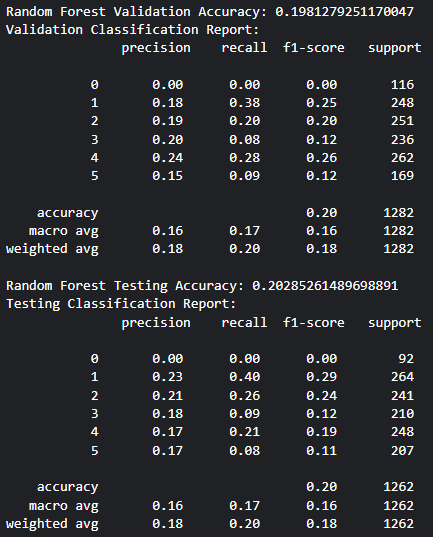_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
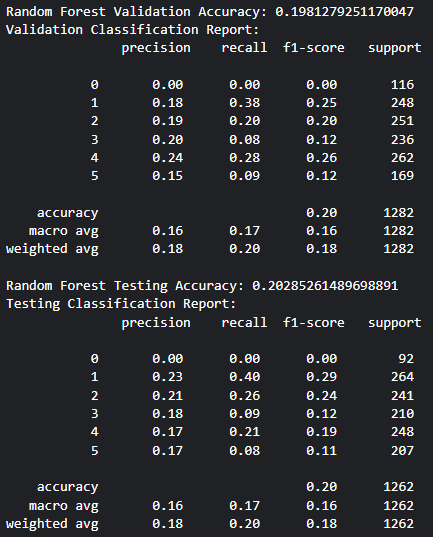

# Logistic Regression Classification
Logistic Regression with Standard Scaling

In [ ]:
# # Initialise Logistic Regression Classifier
# lr_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=seed, multi_class='multinomial', solver='lbfgs'))

# # Train the classifier
# lr_clf.fit(X_train, y_train)

# # Predict on validation set
# lr_pred = lr_clf.predict(X_val)

# # Evaluate
# print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, lr_pred))
# print("Validation Classification Report:\n", classification_report(y_val, lr_pred))

# # Predict on testing set
# lr_test = lr_clf.predict(X_test)

# # Test
# print("Logistic Regression Testing Accuracy:", accuracy_score(y_test, lr_test))
# print("Testing Classification Report:\n", classification_report(y_test, lr_test))

_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
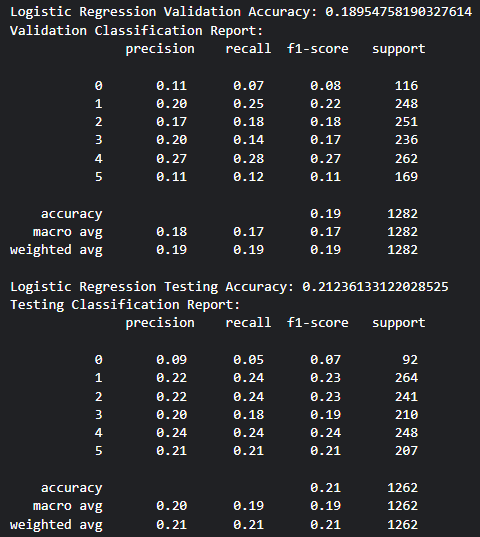

# SVM Classification
SVM with Standard Scaling

In [ ]:
# from sklearn.svm import SVC

# # Initialise SVM Classifier
# svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=seed))

# # Train the classifier
# svm_clf.fit(X_train, y_train)

# # Predict on validation set
# svm_pred = svm_clf.predict(X_val)

# # Evaluate
# print("SVM Validation Accuracy:", accuracy_score(y_val, svm_pred))
# print("Validation Classification Report:\n", classification_report(y_val, svm_pred))

# # Predict on testing set
# svm_test = svm_clf.predict(X_test)

# # Test
# print("SVM Testing Accuracy:", accuracy_score(y_test, svm_test))
# print("Testing Classification Report:\n", classification_report(y_test, svm_test))

_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
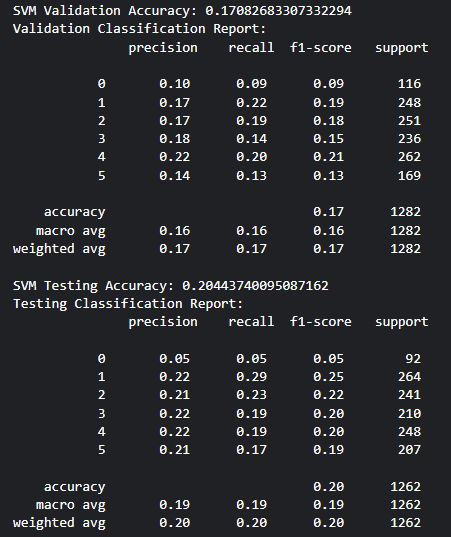

# Data Update

The classification models seem to struggle with the six-way classification. The accuracy scores are only around 20% which seems to be a common theme when using the LIAR dataset with all 6 labels. A recent paper (September 2024, Are Strong Baselines Enough? False News Detection with Machine Learning) by Aslan et. al experimented with this dataset by manipulating the class labels from six classes to two classes. They've done it using 5 different approaches:

1. All labels except "true" are labeled as "false".
2. Labels "pants-fire" and "false" are labeled as "false" and the rest as "true".
3. All labels except "pants-fire" are labeled as "true".
4. Labels are split from the middle into "true" and "false".
5. Labels "true" and "mostly-true" are labeled as "true" and the rest as "false".

They found that option 3 were the best approach as it achieved 91% accuracy. Therefore, for this study we will be using their approach (only using the corresponding Afrikaans labels) to classify the Afrikaans data using only two classes (True or False), as specified in option 3.

**Source:** [Are Strong Baselines Enough? False News Detection with Machine Learning](https://doi.org/10.3390/fi16090322)

**BibTeX Citation:**
```
@Article{fi16090322,
AUTHOR = {Aslan, Lara and Ptaszynski, Michal and Jauhiainen, Jukka},
TITLE = {Are Strong Baselines Enough? False News Detection with Machine Learning},
JOURNAL = {Future Internet},
VOLUME = {16},
YEAR = {2024},
NUMBER = {9},
ARTICLE-NUMBER = {322},
URL = {https://www.mdpi.com/1999-5903/16/9/322},
ISSN = {1999-5903},
ABSTRACT = {False news refers to false, fake, or misleading information presented as real news. In recent years, there has been a noticeable increase in false news on the Internet. The goal of this paper was to study the automatic detection of such false news using machine learning and natural language processing techniques and to determine which techniques work the most effectively. This article first studies what constitutes false news and how it differs from other types of misleading information. We also study the results achieved by other researchers on the same topic. After building a foundation to understand false news and the various ways of automatically detecting it, this article provides its own experiments. These experiments were carried out on four different datasets, one that was made just for this article, using 10 different machine learning methods. The results of this article were satisfactory and provided answers to the original research questions set up at the beginning of this article. This article could determine from the experiments that passive aggressive algorithms, support vector machines, and random forests are the most efficient methods for automatic false news detection. This article also concluded that more complex experiments, such as using multiple levels of identifying false news or detecting computer-generated false news, require more complex machine learning models.},
DOI = {10.3390/fi16090322}
}
```


#### Change and Encode the new labels using binary encoding

In [ ]:
# Copy existing dataframes
new_train_merged_df = train_merged_df.copy()
new_val_merged_df = val_merged_df.copy()
new_test_merged_df = test_merged_df.copy()

# Change the existing labels to binary (1 for if it's not 'broek-vuur', 0 for 'broek-vuur') (OPTION 3)
new_train_merged_df['New Afrikaans Labels'] = (new_train_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_val_merged_df['New Afrikaans Labels'] = (new_val_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_test_merged_df['New Afrikaans Labels'] = (new_test_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_train_merged_df

In [ ]:
new_train_merged_df['New Afrikaans Labels Encoded'] = (new_train_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_val_merged_df['New Afrikaans Labels Encoded'] = (new_val_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_test_merged_df['New Afrikaans Labels Encoded'] = (new_test_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_train_merged_df

In [ ]:
# Update 'New Afrikaans Labels' column in all three dataframes based on the condition
new_train_merged_df['New Afrikaans Labels'] = np.where(new_train_merged_df['New Afrikaans Labels'] == 1, 'waar', 'vals')
new_val_merged_df['New Afrikaans Labels'] = np.where(new_val_merged_df['New Afrikaans Labels'] == 1, 'waar', 'vals')
new_test_merged_df['New Afrikaans Labels'] = np.where(new_test_merged_df['New Afrikaans Labels'] == 1, 'waar', 'vals')

# Display the updated DataFrame
new_train_merged_df

In [ ]:
# Update 'New Afrikaans Labels' column in all three dataframes based on the condition
new_train_merged_df['New English Labels'] = np.where(new_train_merged_df['New Afrikaans Labels'] == 'waar', 'true', 'false')
new_val_merged_df['New English Labels'] = np.where(new_val_merged_df['New Afrikaans Labels'] == 'waar', 'true', 'false')
new_test_merged_df['New English Labels'] = np.where(new_test_merged_df['New Afrikaans Labels'] == 'waar', 'true', 'false')

# Display the updated DataFrame
new_train_merged_df

In [ ]:
csv_new_train_merged_df = pd.merge(train_df, new_train_merged_df, how='left', left_index=True, right_index=True)
csv_new_val_merged_df = pd.merge(val_df, new_val_merged_df, how='left', left_index=True, right_index=True)
csv_new_test_merged_df = pd.merge(test_df, new_test_merged_df, how='left', left_index=True, right_index=True)

In [ ]:
csv_new_train_merged_df = csv_new_train_merged_df.drop(columns=['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels Encoded', 'New Afrikaans Labels Encoded'])
csv_new_val_merged_df = csv_new_val_merged_df.drop(columns=['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels Encoded', 'New Afrikaans Labels Encoded'])
csv_new_test_merged_df = csv_new_test_merged_df.drop(columns=['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels Encoded', 'New Afrikaans Labels Encoded'])
csv_new_train_merged_df

In [ ]:
os.makedirs('/kaggle/working/new_liar_dataset/train', exist_ok=True)
os.makedirs('/kaggle/working/new_liar_dataset/val', exist_ok=True)
os.makedirs('/kaggle/working/new_liar_dataset/test', exist_ok=True)

# Save DataFrames as CSV files
csv_new_train_merged_df.to_csv('/kaggle/working/new_liar_dataset/train/train_data.csv', header=False)
csv_new_val_merged_df.to_csv('/kaggle/working/new_liar_dataset/val/val_data.csv', header=False)
csv_new_test_merged_df.to_csv('/kaggle/working/new_liar_dataset/test/test_data.csv', header=False)

In [ ]:
new_train_merged_df

In [ ]:
unwanted_columns = ['New Afrikaans Labels', 'New English Labels']

new_train_merged_df = new_train_merged_df.drop(columns=unwanted_columns, axis=1)
new_val_merged_df = new_val_merged_df.drop(columns=unwanted_columns, axis=1)
new_test_merged_df = new_test_merged_df.drop(columns=unwanted_columns, axis=1)

new_train_merged_df

#### Update extracted labels

In [ ]:
# Extract labels
y_train = new_train_merged_df['New Afrikaans Labels Encoded']
y_val = new_val_merged_df['New Afrikaans Labels Encoded']
y_test = new_test_merged_df['New Afrikaans Labels Encoded']

print("Training labels distribution:", Counter(y_train))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

#### Balance the training data

In [ ]:
# Instantiate SMOTE
smote = SMOTE(random_state=seed)

# Apply SMOTE to training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new distribution
from collections import Counter
print(f'New training labels distribution: {Counter(y_train_balanced)}')

# Random Forest Classification

In [ ]:
# Initialise Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=seed)

# Train the classifier
rf_clf.fit(X_train_balanced, y_train_balanced)

# Predict on validation set
rf_pred = rf_clf.predict(X_val)

# Evaluate
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
print("Validation Classification Report:\n", classification_report(y_val, rf_pred))

# Predict on testing set
rf_test = rf_clf.predict(X_test)

# Test
print("Random Forest Testing Accuracy:", accuracy_score(y_test, rf_test))
print("Testing Classification Report:\n", classification_report(y_test, rf_test))

_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
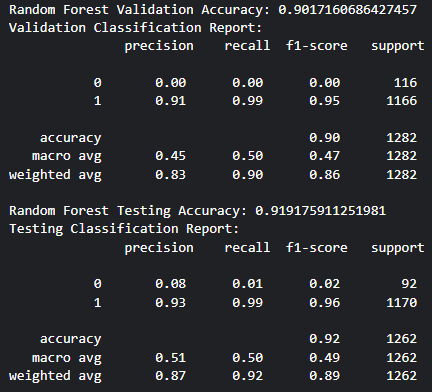

# Logistic Regression Classification
Logistic Regression with Standard Scaling

In [ ]:
# # Initialise Logistic Regression Classifier
# lr_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=seed, multi_class='multinomial', solver='lbfgs'))

# # Train the classifier
# lr_clf.fit(X_train_balanced, y_train_balanced)

# # Predict on validation set
# lr_pred = lr_clf.predict(X_val)

# # Evaluate
# print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, lr_pred))
# print("Validation Classification Report:\n", classification_report(y_val, lr_pred))

# # Predict on testing set
# lr_test = lr_clf.predict(X_test)

# # Test
# print("Logistic Regression Testing Accuracy:", accuracy_score(y_test, lr_test))
# print("Testing Classification Report:\n", classification_report(y_test, lr_test))

_Note the following is an image from the Logistic Regression classification report. This allows us to not having to run the classifier every time to view the results._
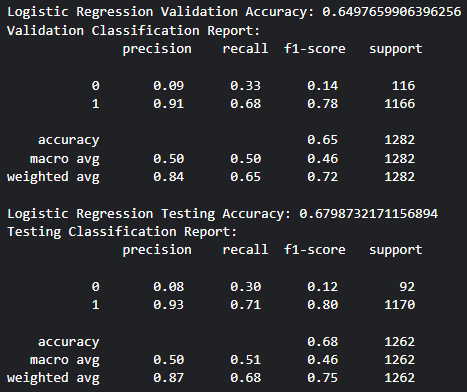

# SVM Classification
SVM with Standard Scaling

In [ ]:
# # Initialise SVM Classifier
# svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=seed))

# # Train the classifier
# svm_clf.fit(X_train_balanced, y_train_balanced)

# # Predict on validation set
# svm_pred = svm_clf.predict(X_val)

# # Evaluate
# print("SVM Validation Accuracy:", accuracy_score(y_val, svm_pred))
# print("Validation Classification Report:\n", classification_report(y_val, svm_pred))

# # Predict on testing set
# svm_test = svm_clf.predict(X_test)

# # Test
# print("SVM Testing Accuracy:", accuracy_score(y_test, svm_test))
# print("Testing Classification Report:\n", classification_report(y_test, svm_test))

_Note the following is an image from the SVM classification report. This allows us to not having to run the classifier every time to view the results._
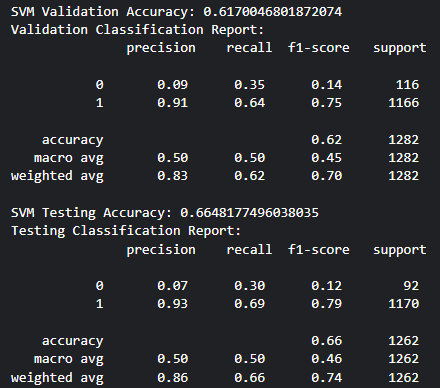

From the classification results we clearly see that the Random Forest classifier achieved the best scores. Therefore, we will use its predictions.

# LIME ( Local Interpretable Model-agnostic Explanations )

In [ ]:
lime_train_df = new_train_merged_df.copy()
lime_train_df = lime_train_df.drop(['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels', 'Afrikaans Labels Encoded'], axis=1)
lime_train_df

In [ ]:
lime_val_df = new_val_merged_df.copy()
lime_val_df = lime_val_df.drop(['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels', 'Afrikaans Labels Encoded'], axis=1)
lime_val_df

In [ ]:
lime_test_df = new_test_merged_df.copy()
lime_test_df = lime_test_df.drop(['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels', 'Afrikaans Labels Encoded'], axis=1)
lime_test_df

In [ ]:
def get_feature_names(dataframe_row):
    return dataframe_row.split(' ')   

In [ ]:
get_feature_names(lime_train_df.iloc[0, 0])

#### Create a pipeline from the previous models (i.e. BERT, Random Forest) with the LIME model

In [ ]:
class BertEmbeddingExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_file=None, set_split=None, model_name='bert-base-multilingual-cased', random_state=99):
        self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.eval()  # Set model to evaluation mode
        self.embeddings = None
        self.embedding_file = embedding_file
        self.set_split = set_split
        self.random_state = random_state

    def transform(self, texts, y=None, embedding_file=None, set_split=None):
        # If no embedding file is provided, raise an error
        if self.embedding_file is None and embedding_file is None:
            raise ValueError("An embedding file must be provided.")
            
        # If no set split is specified, raise an error
        if self.set_split is None and set_split is None:
            raise ValueError("The dataset split should be specified (e.g. 'train').")
        
        # Handle cases for validation and testing files
        if self.embedding_file != embedding_file and embedding_file is not None:
            self.embedding_file = embedding_file
            
        if self.set_split != set_split and set_split is not None:
            self.set_split = set_split

        # Check if the embedding file exists
        if os.path.exists(self.embedding_file):            
            self.embeddings = np.load(self.embedding_file)
            print(f"Loaded existing embeddings from {self.embedding_file}.")
            
            # Apply SMOTE if in 'train' set
            if self.set_split == 'train' and y is not None:
                print(f"Balancing embeddings for training set with SMOTE.")
                smote = SMOTE(random_state=self.random_state)
                X_balanced, y_balanced = smote.fit_resample(self.embeddings, y)
                self.embeddings = X_balanced
                return X_balanced, y_balanced
            
            return self.embeddings

        # If embeddings need to be extracted
        embeddings = []
        for text in texts:
            encoded_input = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
            with torch.no_grad():  # Disable gradient calculation
                outputs = self.model(**encoded_input)
                # Extract the mean of the last hidden states
                embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(embedding)
        
        self.embeddings = np.array(embeddings)
        embedding_output_file = f"/kaggle/working/bert-af-embeddings/{self.set_split}_af_embeddings.npy"
        np.save(embedding_output_file, self.embeddings)  # Save embeddings to file
        print(f"Extracted and saved new embeddings to {embedding_output_file}.")
        
        # Apply SMOTE if in 'train' set
        if self.set_split == 'train' and y is not None:
            print(f"Balancing embeddings for training set with SMOTE.")
            smote = SMOTE(random_state=self.random_state)
            X_balanced, y_balanced = smote.fit_resample(self.embeddings, y)
            self.embeddings = X_balanced
            return X_balanced, y_balanced
        
        return self.embeddings

    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformer

In [ ]:
# Copy existing dataframes
new_train_merged_df = train_merged_df.copy()
new_val_merged_df = val_merged_df.copy()
new_test_merged_df = test_merged_df.copy()

# Change the existing labels to binary (1 for if it's not 'broek-vuur', 0 for 'broek-vuur')
new_train_merged_df['New Afrikaans Labels Encoded'] = (new_train_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_val_merged_df['New Afrikaans Labels Encoded'] = (new_val_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_test_merged_df['New Afrikaans Labels Encoded'] = (new_test_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)

# Extract labels
y_train = new_train_merged_df['New Afrikaans Labels Encoded']
y_val = new_val_merged_df['New Afrikaans Labels Encoded']
y_test = new_test_merged_df['New Afrikaans Labels Encoded']

print("Training labels distribution:", Counter(y_train))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

In [ ]:
# Define embedding file paths
train_embedding_input_file = "/kaggle/input/bert-af-embeddings/train_af_embeddings.npy"
val_embedding_input_file = "/kaggle/input/bert-af-embeddings/val_af_embeddings.npy"
test_embedding_input_file = "/kaggle/input/bert-af-embeddings/test_af_embeddings.npy"

# Initialise the extractor
bert_extractor = BertEmbeddingExtractor()

# Ensure output directory exists
output_dir = "/kaggle/working/bert-af-embeddings"
os.makedirs(output_dir, exist_ok=True)

# Extract embeddings for each dataset
training_embeddings, y_train_balanced = bert_extractor.transform(new_train_merged_df['Afrikaans Sentence'], y_train, train_embedding_input_file, 'train')
validation_embeddings = bert_extractor.transform(new_val_merged_df['Afrikaans Sentence'], None, val_embedding_input_file, 'val')
testing_embeddings = bert_extractor.transform(new_test_merged_df['Afrikaans Sentence'], None, test_embedding_input_file, 'test')

In [ ]:
# Extract features
X_train_balanced = training_embeddings
X_val = validation_embeddings
X_test = testing_embeddings

print("Training labels distribution:", Counter(y_train_balanced))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

In [ ]:
# Initialize Random Forest Classifier 
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

class BertEmbeddingPipeline:
    def __init__(self, embedding_file, set_split, classifier):
        self.bert_extractor = BertEmbeddingExtractor(embedding_file, set_split)
        self.classifier = classifier
        self.embedding_file = embedding_file
        self.set_split = set_split

    def fit(self, X, y, is_balanced=False):
        # Set the embedding file and split for training
        self.bert_extractor.embedding_file = self.bert_extractor.embedding_file
        self.bert_extractor.set_split = self.bert_extractor.set_split
        
        if is_balanced == False:
            # Extract embeddings for training data
            self.embeddings, balanced_y = self.bert_extractor.transform(X, y)
            self.classifier.fit(self.embeddings, balanced_y)
        else:
            self.embeddings = X
            self.classifier.fit(self.embeddings, y)

    def predict(self, X, embedding_file=None, set_split=None):
        if embedding_file is None:
            embedding_file = self.embedding_file
        
        if set_split is None:
            set_split = self.set_split
            
        # Set the embedding file and split for prediction
        self.bert_extractor.embedding_file = embedding_file
        self.bert_extractor.set_split = set_split
        embeddings = self.bert_extractor.transform(X)
        return self.classifier.predict(embeddings)

# Create a custom pipeline instance
pipeline = BertEmbeddingPipeline(train_embedding_input_file, 'train', rf_clf)

# Fit the classifier on training set
pipeline.fit(X_train_balanced, y_train_balanced, is_balanced=True)

# Predict on validation set
rf_pred = pipeline.predict(new_val_merged_df['Afrikaans Sentence'], val_embedding_input_file, 'val')

# Evaluate on validation set
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
print("Validation Classification Report:\n", classification_report(y_val, rf_pred))

# Predict on testing set
rf_test = pipeline.predict(new_test_merged_df['Afrikaans Sentence'], test_embedding_input_file, 'test')

# Test on the test set
print("Random Forest Testing Accuracy:", accuracy_score(y_test, rf_test))
print("Testing Classification Report:\n", classification_report(y_test, rf_test))

In [ ]:
def explain_prediction(pipeline, text, embedding_file, set_split, num_samples):
    # Use LIME to explain the prediction
    print('Getting LIME explanation...\n')
    
    # Function to predict probabilities for LIME
    def predict_proba_fn(texts):
        # Generate embeddings
        embeddings = pipeline.bert_extractor.transform(texts, embedding_file, set_split)
        print(f"Embeddings shape: {embeddings.shape}")
        
        return pipeline.classifier.predict_proba(embeddings)

    # Initialise LIME Text Explainer
    explainer = LimeTextExplainer(class_names=['Misinformation', 'Truthful'])

    # Call explain_instance with the original text and the prediction function
    exp = explainer.explain_instance(text, predict_proba_fn, num_features=len(text), num_samples=num_samples, top_labels=1)

    # Display the explanation
    exp.show_in_notebook(text=True)
    
    return exp

def bold_text(text):
    return "\033[1m" + text + "\033[0m"

def generate_human_readable_explanations(important_features, prediction, true_label):
    predicted_class = 'Truthful' if prediction == 1 else 'Misinformation'
    true_class = 'Truthful' if true_label == 1 else 'Misinformation'

    # Check if the model predicted correctly or incorrectly
    correct_prediction = prediction == true_label
    result = "correctly" if correct_prediction else "incorrectly"
    joiner = "and" if correct_prediction else "while"

    # Generate the human-readable explanation
    explanation_text = f"The model {result} predicted this text as {bold_text(predicted_class)}, {joiner} the actual class was {bold_text(true_class)}.\n"
    
    # Add interpretation based on the weights
    for feature, weight in important_features:
        if prediction == 1:  # Predicted 'Truthful'
            if weight > 0:
                explanation_text += f"• '{feature}' supported {bold_text('Truthful')} (positive weight: {weight:.5f}).\n"
            else:
                explanation_text += f"• '{feature}' opposed {bold_text('Truthful')} (negative weight: {weight:.5f}), contributing to 'Misinformation'.\n"
        else:  # Predicted 'Misinformation'
            if weight > 0:
                explanation_text += f"• '{feature}' oppposed {bold_text('Misinformation')} (positive weight: {weight:.5f}), contributing to 'Truthful'.\n"
            else:
                explanation_text += f"• '{feature}' supported {bold_text('Misinformation')} (negative weight: {weight:.5f}).\n"
    
    # Final conclusion
    explanation_text += f"\nIn this instance, the model's important features led it to predict {bold_text(predicted_class)}."

    if not correct_prediction:
        explanation_text += f" However, the true class was {bold_text(true_class)}, suggesting that the model misinterpreted some key features."

    print(explanation_text)

#### Let us view a correctly predicted instance
(Should have been predicted as '1' (Truthful), and was predicted as '1' (Truthful))

In [ ]:
# Show explanation
index_to_explain = 0
text_to_explain = new_test_merged_df['Afrikaans Sentence'].iloc[index_to_explain]

# Use the test embedding file and set split
explanation = explain_prediction(
    pipeline,
    text_to_explain,
    embedding_file=test_embedding_input_file,
    set_split='test',
    num_samples=new_test_merged_df.shape[0]
)

In [ ]:
# Extract and format the explanation from LIME
if rf_test[index_to_explain] == 0:
    important_features = explanation.as_list(label=0)
else:
    important_features = explanation.as_list()
    
generate_human_readable_explanations(important_features, rf_test[index_to_explain], y_test[index_to_explain])

#### Let us view a wrongly predicted instance
(Should have been predicted as '0' (Misinformation), but was predicted as '1' (Truthful))

In [ ]:
# Show explanation
index_to_explain = 4
text_to_explain = new_test_merged_df['Afrikaans Sentence'].iloc[index_to_explain]

# Use the test embedding file and set split
explanation = explain_prediction(
    pipeline,
    text_to_explain,
    embedding_file=test_embedding_input_file,
    set_split='test',
    num_samples=new_test_merged_df.shape[0]
)

In [ ]:
# Extract and format the explanation from LIME
if rf_test[index_to_explain] == 0:
    important_features = explanation.as_list(label=0)
else:
    important_features = explanation.as_list()

generate_human_readable_explanations(important_features, rf_test[index_to_explain], y_test[index_to_explain])

#### Let's look at another wrongly predicted instance
Should have predicted as '1' (Truthful) but was predicted as '0' (Misinformation)

In [ ]:
# Show explanation
index_to_explain = 170
text_to_explain = new_test_merged_df['Afrikaans Sentence'].iloc[index_to_explain]

# Use the test embedding file and set split
explanation = explain_prediction(
    pipeline,
    text_to_explain,
    embedding_file=test_embedding_input_file,
    set_split='test',
    num_samples=new_test_merged_df.shape[0]
)

In [ ]:
# Extract and format the explanation from LIME
if rf_test[index_to_explain] == 0:
    important_features = explanation.as_list(label=0)
else:
    important_features = explanation.as_list()

generate_human_readable_explanations(important_features, rf_test[index_to_explain], y_test[index_to_explain])

#### Reason for misclassification

Despite balancing our training data, the model continued to misclassify some instances. This could be due to the potential bias created during the re-labeling of dataset classes with OPTION 3. Furthermore, this re-labeling approach could have been more effective with the original English data, resulting in better predictions.

However, it is worth noting that the classification model had high accuracy scores across all datasets (training, validation, and testing). Furthermore, the creation of human-readable explanations revealed how the LIME model mostly understands the classifier's behaviour correctly, providing important insights into its decision-making process. A possible solution to solve the problem may be to combine several Afrikaans-translated fake news datasets to increase the number of resources available for training, validation, and testing sets. 
